<a href="https://colab.research.google.com/github/leakydishes/AppTruckSharing/blob/main/data_clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div class="chatbot-title"><b>AI Chatbot: </b> Alcohol and Drug Foundation (ADF)</div>

<div class="chatbot-authors"><b>Project Manager: </b>Dotahn</div>

<div class="chatbot-authors"><b>Authored by (interns): </b>Te' Claire and Khuzaima Jamil</div>

<div class="chatbot-dates"><b>Dates: </b>December 2023/ January, February 2024</div>

<div class="chatbot-github"><b>GitHub Repo: </b>
<a href="https://github.com/Dotahn/ADFAIChatbot-Internship/tree/main"> Github Link</a></div>

<br>


---


<br>

##### Overview:
1. Set-up, inserts **'WebcrawlerInsert'** table (JSON) from Supabase & Examines Dataset.
2. Part 1 Identify and Remove Irrelevant Data, check data types, case normalisation
3. Export cleaned data to supabase as **cleandata'** table (JSON)
4.  Part 2 Anonymize Information & Visualisation, exclude numbers from search, Trends, Temporal Trends & LDA Topic Modelling

##### Aims:
- A vector database of the information contained in the ADF website
Development of an automated system which scrapes all content provided via the ADF website and breaks it down into small pieces of information.
Information is stores in a database which considers the relationship between concepts and the semantic meaning of the information.
Database allows for intuitive and rapid search (ensuring information provided by the chatbot is accurate and relevant to the intent of the person using it.

##### Notes:
- Cleaned target sentence must preserve the original semantic content, ensuring it conveys the intended meaning of the noisy source sentence, thus maintaining the accuracy and fidelity of the translation [2].
- Additionally, The quality of the data ingested greatly impacts the efficiency and accuracy of these results [3].
- Data cleaning is filtering the webcrawled data to explore, understand, and model [4].

##### Benefits:
- Enhances Model Accuracy: Clean data means the LLM can learn patterns and language more effectively [1], [2].
- Reduces Bias: Removing inappropriate or irrelevant data, the risk of perpetuating biases is significantly reduced [3], [4].
- Saves Time and Resources: A well-cleaned dataset means less time spent on troubleshooting and recalibrating the model post-deployment [5].
- Improves Decision-making: For businesses, clean data ensures that the insights and decisions driven by the LLM are based on accurate information [6], [7].

##### RAM Usage Rate Google Collab
- Usage rate: approximately 0.08 per hour
- Python 3 Google Compute Engine backend


#### **Cleaned Dataset Output**
- `#`: The unique identifier for data
- `url`: The url of data
- `text`: Data information/ text
- `markdown`: Collective information from all rows
- `last_updated`: Data last updated
- `title`: Title of text
- `description`: Description of text
- `slang_terms`: Other names of text titles(drug-facts)
- `url_reduced`: HTML removed from URL



References
<br>
[1] https://www.lettria.com/blogpost/data-cleaning-before-training-an-llm <br>
[2] https://multiplatform.ai/researchers-showcase-the-effectiveness-of-ai-in-data-cleaning/
<br>
[3] https://sreent.medium.com/fine-tuning-and-evaluating-large-language-models-llms-f38f245f87f9
<br>
[4] https://medium.com/p/b713dbd49726
<br>
[5] https://slator.com/large-language-models-really-good-at-data-cleaning-research-finds/
<br>
[6] https://www.lettria.com/blogpost/data-cleaning-before-training-an-llm
<br>
[7] https://medium.com/@meta_heuristic/3-must-have-techniques-for-data-ingestion-into-llm-and-langchain-1cd751477be


## Set Up

In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.decomposition import LatentDirichletAllocation
import missingno as msno
import datetime as dt
import json, requests, urllib, io, re, ast
import seaborn as sns

# Import Google Collab
import os
import matplotlib.pyplot as plt
from google.colab import drive

In [2]:
# Mount drive
drive.mount('/content/drive',force_remount=True)
%cd /content/drive/MyDrive/ADFAIChatbot/python_scripts
!ls

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1OP0r8cO6DFjxo5iF0yrlyXaRPCme93DI/ADFAIChatbot/python_scripts
data		  embeddings_claude.ipynb   embeddings_utils.py  qdrant_openai.ipynb
data_clean.ipynb  embeddings_mistral.ipynb  model_openai.ipynb	 rag_openAI.ipynb
data.json	  embeddings_openAI.ipynb   __pycache__		 webcrawler_apify.ipynb


In [3]:
# Optional code
###########################################################
# Show max width of columns in Google Collab ->
# pd.set_option('display.max_colwidth', None)
###########################################################
# Show min width of columns in Google Collab ->
pd.reset_option('display.max_colwidth')
###########################################################

In [4]:
# API and URL Keys
file_path = "/content/drive/MyDrive/ADFAIChatbot/secrets/secrets.json"
# Read JSON object
with open(file_path, "r") as file:
      keys = json.load(file)
      supabase_token = keys["supabaseKey"]
      supabase_url = keys["supabaseUrl"]

In [5]:
# Primary Color Palette
black = '#000000'
white = '#FFFFFF'
red = '#E02F3E'

# Secondary Color Palette
green = '#66D19E'
yellow = '#FDD65B'
blue = '#67C6EC'

### Supabase Set Up
- API request
- GET Request (retrieve the data from table)
- Convert Data to Dataframe

In [6]:
# Supabase
supabase_url = supabase_url
supabase_api_key = supabase_token
table_name = "WebcrawlerInsert" # Apify

# Set up Headers
headers = {
    "Content-Type": "application/json",
    "apikey": supabase_api_key,
    "Authorization": f"Bearer {supabase_api_key}"
}

api_endpoint = f"{supabase_url}/rest/v1/{table_name}" # API endpoint
response = requests.get(api_endpoint, headers=headers) # Fetch data

# Request Check
if response.status_code == 200:
    data_input = response.json()
    # Convert JSON data to dataFrame
    data = pd.DataFrame(data_input)
    print("Data loaded into DataFrame successfully.")
else:
    print(f"Error: {response.status_code} - {response.text}")

Data loaded into DataFrame successfully.


### Examine dataset

In [7]:
data

,id,created_at,crawl,markdown,metadata,screenshoturl,text,url
0,2971,2024-01-24T05:15:47.010268+00:00,{'loadedUrl': 'https://adf.org.au/drug-facts/a...,"# Amyl nitrite\n\nLast published: November 23,...",{'canonicalUrl': 'https://adf.org.au/drug-fact...,None,"Amyl nitrite\nLast published: November 23, 202...",https://adf.org.au/drug-facts/amyl-nitrite/
1,2972,2024-01-24T05:15:47.010268+00:00,{'loadedUrl': 'https://adf.org.au/drug-facts/s...,# Anabolic steroids\n\nLast published: Novembe...,{'canonicalUrl': 'https://adf.org.au/drug-fact...,None,Anabolic steroids\nLast published: November 22...,https://adf.org.au/drug-facts/steroids/
2,2973,2024-01-24T05:15:47.010268+00:00,{'loadedUrl': 'https://adf.org.au/drug-facts/a...,"# Aspirin\n\nLast published: December 21, 2023...",{'canonicalUrl': 'https://adf.org.au/drug-fact...,None,"Aspirin\nLast published: December 21, 2023\nWh...",https://adf.org.au/drug-facts/aspirin/
3,2974,2024-01-24T05:15:47.010268+00:00,{'loadedUrl': 'https://adf.org.au/drug-facts/b...,# Benzodiazepines\n\nLast published: November ...,{'canonicalUrl': 'https://adf.org.au/drug-fact...,None,"Benzodiazepines\nLast published: November 22, ...",https://adf.org.au/drug-facts/benzodiazepines/
4,2975,2024-01-24T05:15:47.010268+00:00,{'loadedUrl': 'https://adf.org.au/drug-facts/a...,"# Ayahuasca\n\nLast published: December 07, 20...",{'canonicalUrl': 'https://adf.org.au/drug-fact...,None,"Ayahuasca\nLast published: December 07, 2023\n...",https://adf.org.au/drug-facts/ayahuasca/
...,...,...,...,...,...,...,...,...
490,3461,2024-01-24T05:15:47.010268+00:00,{'loadedUrl': 'https://adf.org.au/drug-facts/p...,"# Paracetamol\n\nLast published: December 07, ...",{'canonicalUrl': 'https://adf.org.au/drug-fact...,None,"Paracetamol\nLast published: December 07, 2023...",https://adf.org.au/drug-facts/paracetamol/
491,3462,2024-01-24T05:15:47.010268+00:00,{'loadedUrl': 'https://adf.org.au/drug-facts/p...,# Performance & image enhancing drugs\n\nLast ...,{'canonicalUrl': 'https://adf.org.au/drug-fact...,None,Performance & image enhancing drugs\nLast publ...,https://adf.org.au/drug-facts/pieds/
492,3463,2024-01-24T05:15:47.010268+00:00,{'loadedUrl': 'https://adf.org.au/drug-facts/p...,"# PMA and PMMA\n\nLast published: January 18, ...",{'canonicalUrl': 'https://adf.org.au/drug-fact...,None,"PMA and PMMA\nLast published: January 18, 2024...",https://adf.org.au/drug-facts/pma-and-pmma/
493,3464,2024-01-24T05:15:47.010268+00:00,{'loadedUrl': 'https://adf.org.au/drug-facts/p...,# Psilocybin (magic mushrooms)\n\nLast publish...,{'canonicalUrl': 'https://adf.org.au/drug-fact...,None,Psilocybin (magic mushrooms)\nLast published: ...,https://adf.org.au/drug-facts/psilocybin/


In [8]:
num_records = data.shape[0]
print(f"Number of data records in the DataFrame: {num_records}")

Number of data records in the DataFrame: 495


### Part 1 Identify and Remove Irrelevant Data
##### Identify data that is relevant to the specific task of the LLM.
*   Create new dataframe
*   Drop empty columns from dataset
*   Examine missing records
*   Check duplicate values
*   Check Data Types
*   Remove Unnecessary Columns
*   remove special characters, symbols, and HTML tags
*   Case normalisation (upper/lower)

<!-- <font color='red'>TO DO</font>
*   Case normalisation (upper/lower)-->

In [9]:
# Find missing values
missing_values = data.isna().sum()
missing_values

id               0
created_at       0
crawl            0
markdown         0
metadata         0
screenshoturl    0
text             0
url              0
dtype: int64

#####Remove Empty URLs

In [10]:
num_records = data.shape[0]
print(f"Number of data records in the DataFrame: {num_records}")

Number of data records in the DataFrame: 495


#####Drop empty columns from dataset
##### Python Script 1 produced only NaN for 'screenshotUrl' column.
##### Manual Data set included columns ['metadata/author','screenshotUrl', 'metadata/keywords', 'metadata/languageCode']

In [11]:
data = data.drop(columns=['screenshoturl'], axis=1)
data
data.isnull().sum()

id            0
created_at    0
crawl         0
markdown      0
metadata      0
text          0
url           0
dtype: int64

##### Check duplicate values

In [12]:
# Check duplicates
duplicates = data.duplicated()
num_duplicates = duplicates.sum()

duplicate_rows = data[duplicates]
print("Number of duplicate rows:", num_duplicates)
print("Duplicate rows:")
print(duplicate_rows)

Number of duplicate rows: 0
Duplicate rows:
Empty DataFrame
Columns: [id, created_at, crawl, markdown, metadata, text, url]
Index: []


##### Extract Last Updated




In [13]:
def extract_last_updated(text):
    pattern = r'Last updated: (\d{2} \w+ \d{4})'
    match = re.search(pattern, text)
    if match:
        return match.group(1)
    else:
        return None

data['last_updated'] = data['text'].apply(extract_last_updated)
data.head()

,id,created_at,crawl,markdown,metadata,text,url,last_updated
0,2971,2024-01-24T05:15:47.010268+00:00,{'loadedUrl': 'https://adf.org.au/drug-facts/a...,"# Amyl nitrite\n\nLast published: November 23,...",{'canonicalUrl': 'https://adf.org.au/drug-fact...,"Amyl nitrite\nLast published: November 23, 202...",https://adf.org.au/drug-facts/amyl-nitrite/,23 Nov 2023
1,2972,2024-01-24T05:15:47.010268+00:00,{'loadedUrl': 'https://adf.org.au/drug-facts/s...,# Anabolic steroids\n\nLast published: Novembe...,{'canonicalUrl': 'https://adf.org.au/drug-fact...,Anabolic steroids\nLast published: November 22...,https://adf.org.au/drug-facts/steroids/,22 Nov 2023
2,2973,2024-01-24T05:15:47.010268+00:00,{'loadedUrl': 'https://adf.org.au/drug-facts/a...,"# Aspirin\n\nLast published: December 21, 2023...",{'canonicalUrl': 'https://adf.org.au/drug-fact...,"Aspirin\nLast published: December 21, 2023\nWh...",https://adf.org.au/drug-facts/aspirin/,21 Dec 2023
3,2974,2024-01-24T05:15:47.010268+00:00,{'loadedUrl': 'https://adf.org.au/drug-facts/b...,# Benzodiazepines\n\nLast published: November ...,{'canonicalUrl': 'https://adf.org.au/drug-fact...,"Benzodiazepines\nLast published: November 22, ...",https://adf.org.au/drug-facts/benzodiazepines/,22 Nov 2023
4,2975,2024-01-24T05:15:47.010268+00:00,{'loadedUrl': 'https://adf.org.au/drug-facts/a...,"# Ayahuasca\n\nLast published: December 07, 20...",{'canonicalUrl': 'https://adf.org.au/drug-fact...,"Ayahuasca\nLast published: December 07, 2023\n...",https://adf.org.au/drug-facts/ayahuasca/,07 Dec 2023


In [14]:
# Find missing values in each column
missing_values = data.isna().sum()
missing_values

id              0
created_at      0
crawl           0
markdown        0
metadata        0
text            0
url             0
last_updated    0
dtype: int64

In [15]:
print(data['text'].str.contains('Last updated').sum())

495


##### Lack of results 'last published'
##### reduced_wc_gc_data['Last published'] droped at end

In [16]:
# Find list of records that don't have "Last updated"
No_Last_Update = data[~data['text'].str.contains('Last updated')]
No_Last_Update.shape

(0, 8)

#### Create Title from Metadata

In [17]:
def extract_title_from_metadata(metadata):
    try:
        metadata_dict = ast.literal_eval(metadata) # Convert to dict
        return metadata_dict.get('title', None) # Get title
    except:
        return None

data['title'] = data['metadata'].apply(extract_title_from_metadata)
print(data[['metadata', 'title']].head())

                                            metadata  \
0  {'canonicalUrl': 'https://adf.org.au/drug-fact...   
1  {'canonicalUrl': 'https://adf.org.au/drug-fact...   
2  {'canonicalUrl': 'https://adf.org.au/drug-fact...   
3  {'canonicalUrl': 'https://adf.org.au/drug-fact...   
4  {'canonicalUrl': 'https://adf.org.au/drug-fact...   

                                           title  
0     Amyl Nitrite - Alcohol and Drug Foundation  
1         Steroids - Alcohol and Drug Foundation  
2           Asprin - Alcohol and Drug Foundation  
3  Benzodiazepines - Alcohol and Drug Foundation  
4        Ayahuasca - Alcohol and Drug Foundation  


#### Remove from text 'Alcohol and Drug Foundation'

In [18]:
def remove_ADF_text(text):
  return text.replace("- Alcohol and Drug Foundation", '')

data['title'] = data['title'].apply(remove_ADF_text)
data.head()

,id,created_at,crawl,markdown,metadata,text,url,last_updated,title
0,2971,2024-01-24T05:15:47.010268+00:00,{'loadedUrl': 'https://adf.org.au/drug-facts/a...,"# Amyl nitrite\n\nLast published: November 23,...",{'canonicalUrl': 'https://adf.org.au/drug-fact...,"Amyl nitrite\nLast published: November 23, 202...",https://adf.org.au/drug-facts/amyl-nitrite/,23 Nov 2023,Amyl Nitrite
1,2972,2024-01-24T05:15:47.010268+00:00,{'loadedUrl': 'https://adf.org.au/drug-facts/s...,# Anabolic steroids\n\nLast published: Novembe...,{'canonicalUrl': 'https://adf.org.au/drug-fact...,Anabolic steroids\nLast published: November 22...,https://adf.org.au/drug-facts/steroids/,22 Nov 2023,Steroids
2,2973,2024-01-24T05:15:47.010268+00:00,{'loadedUrl': 'https://adf.org.au/drug-facts/a...,"# Aspirin\n\nLast published: December 21, 2023...",{'canonicalUrl': 'https://adf.org.au/drug-fact...,"Aspirin\nLast published: December 21, 2023\nWh...",https://adf.org.au/drug-facts/aspirin/,21 Dec 2023,Asprin
3,2974,2024-01-24T05:15:47.010268+00:00,{'loadedUrl': 'https://adf.org.au/drug-facts/b...,# Benzodiazepines\n\nLast published: November ...,{'canonicalUrl': 'https://adf.org.au/drug-fact...,"Benzodiazepines\nLast published: November 22, ...",https://adf.org.au/drug-facts/benzodiazepines/,22 Nov 2023,Benzodiazepines
4,2975,2024-01-24T05:15:47.010268+00:00,{'loadedUrl': 'https://adf.org.au/drug-facts/a...,"# Ayahuasca\n\nLast published: December 07, 20...",{'canonicalUrl': 'https://adf.org.au/drug-fact...,"Ayahuasca\nLast published: December 07, 2023\n...",https://adf.org.au/drug-facts/ayahuasca/,07 Dec 2023,Ayahuasca


In [19]:
# Find all the titles
unique_titles = data['title'].unique()
print(unique_titles)

['Amyl Nitrite ' 'Steroids ' 'Asprin ' 'Benzodiazepines ' 'Ayahuasca '
 'Buprenorphine ' 'Betel Nut ' 'Buprenorphine - Long Acting Injectable '
 'Butane hash oil ' 'Caffeine ' 'Cannabinoids ' 'Cannabis ' 'Cocaine '
 'Codeine ' 'Depressants ' 'Dissociatives ' 'DMT '
 'Vaping (e-cigarettes) ' 'Empathogens ' 'Ethylone ' 'Fentanyl ' 'GHB '
 'Heroin ' 'Ibuprofen ' 'Ice (Crystal methamphetamine) '
 'Help and support by state ' 'the Power of Words ' 'ADF Library '
 'How to search ' 'How to use resources ' 'ADF Library help ' 'Alcohol '
 'Your Library account ' 'Join the ADF Library ' 'Feedback and Requests '
 'test ' 'Library Stakeholder Kit ' 'Amphetamines ' 'NBOMes '
 'ADF Library terms & conditions ' 'Thank you for joining ADF Library '
 'Outcomes framework ' 'Journal selection ' 'Using Social Media '
 'Facebook tiles ' 'Twitter tiles '
 'Drug Information Directory – Stakeholder Kits '
 'Drug information directory Glossary ' 'ADF Shop '
 'Path2Help Campaign Kit 2022 ' 'Drug Facts '
 'The A

#### Create 'Description'

In [20]:
# Convert dict 'metadata'
data['metadata'] = data['metadata'].apply(ast.literal_eval)

# Find 'description' from dict
data['description'] = data['metadata'].apply(lambda x: x.get('description') if isinstance(x, dict) else None)
data.head()

,id,created_at,crawl,markdown,metadata,text,url,last_updated,title,description
0,2971,2024-01-24T05:15:47.010268+00:00,{'loadedUrl': 'https://adf.org.au/drug-facts/a...,"# Amyl nitrite\n\nLast published: November 23,...",{'canonicalUrl': 'https://adf.org.au/drug-fact...,"Amyl nitrite\nLast published: November 23, 202...",https://adf.org.au/drug-facts/amyl-nitrite/,23 Nov 2023,Amyl Nitrite,"Amyl nitrite's effects, a depressant known for..."
1,2972,2024-01-24T05:15:47.010268+00:00,{'loadedUrl': 'https://adf.org.au/drug-facts/s...,# Anabolic steroids\n\nLast published: Novembe...,{'canonicalUrl': 'https://adf.org.au/drug-fact...,Anabolic steroids\nLast published: November 22...,https://adf.org.au/drug-facts/steroids/,22 Nov 2023,Steroids,"Anabolic steroids, their medical uses, and non..."
2,2973,2024-01-24T05:15:47.010268+00:00,{'loadedUrl': 'https://adf.org.au/drug-facts/a...,"# Aspirin\n\nLast published: December 21, 2023...",{'canonicalUrl': 'https://adf.org.au/drug-fact...,"Aspirin\nLast published: December 21, 2023\nWh...",https://adf.org.au/drug-facts/aspirin/,21 Dec 2023,Asprin,Aspirin (acetylsalicylic acid) is a pharmaceut...
3,2974,2024-01-24T05:15:47.010268+00:00,{'loadedUrl': 'https://adf.org.au/drug-facts/b...,# Benzodiazepines\n\nLast published: November ...,{'canonicalUrl': 'https://adf.org.au/drug-fact...,"Benzodiazepines\nLast published: November 22, ...",https://adf.org.au/drug-facts/benzodiazepines/,22 Nov 2023,Benzodiazepines,"Understand benzodiazepines, their effects, ris..."
4,2975,2024-01-24T05:15:47.010268+00:00,{'loadedUrl': 'https://adf.org.au/drug-facts/a...,"# Ayahuasca\n\nLast published: December 07, 20...",{'canonicalUrl': 'https://adf.org.au/drug-fact...,"Ayahuasca\nLast published: December 07, 2023\n...",https://adf.org.au/drug-facts/ayahuasca/,07 Dec 2023,Ayahuasca,"Ayahuasca's psychedelic effects, its tradition..."


### Create attribute (column) for Other terms
- pd.Series.str.extract

In [21]:
# Find other terms using drug-facts 'url'
def extract_other_names(text):
    pattern = r"Other names\n(.*?)\n"
    match = re.search(pattern, text, re.DOTALL)
    if match:
        return match.group(1)
    else:
        return None

# Create Column
data['other_terms'] = data['text'].apply(extract_other_names)
data.head()


,id,created_at,crawl,markdown,metadata,text,url,last_updated,title,description,other_terms
0,2971,2024-01-24T05:15:47.010268+00:00,{'loadedUrl': 'https://adf.org.au/drug-facts/a...,"# Amyl nitrite\n\nLast published: November 23,...",{'canonicalUrl': 'https://adf.org.au/drug-fact...,"Amyl nitrite\nLast published: November 23, 202...",https://adf.org.au/drug-facts/amyl-nitrite/,23 Nov 2023,Amyl Nitrite,"Amyl nitrite's effects, a depressant known for...","Poppers, Jungle Juice, liquid gold, rush, purp..."
1,2972,2024-01-24T05:15:47.010268+00:00,{'loadedUrl': 'https://adf.org.au/drug-facts/s...,# Anabolic steroids\n\nLast published: Novembe...,{'canonicalUrl': 'https://adf.org.au/drug-fact...,Anabolic steroids\nLast published: November 22...,https://adf.org.au/drug-facts/steroids/,22 Nov 2023,Steroids,"Anabolic steroids, their medical uses, and non...","Roids, gear, juice, stackers, gym candy, arnol..."
2,2973,2024-01-24T05:15:47.010268+00:00,{'loadedUrl': 'https://adf.org.au/drug-facts/a...,"# Aspirin\n\nLast published: December 21, 2023...",{'canonicalUrl': 'https://adf.org.au/drug-fact...,"Aspirin\nLast published: December 21, 2023\nWh...",https://adf.org.au/drug-facts/aspirin/,21 Dec 2023,Asprin,Aspirin (acetylsalicylic acid) is a pharmaceut...,Aspirin may also be known by its brand or trad...
3,2974,2024-01-24T05:15:47.010268+00:00,{'loadedUrl': 'https://adf.org.au/drug-facts/b...,# Benzodiazepines\n\nLast published: November ...,{'canonicalUrl': 'https://adf.org.au/drug-fact...,"Benzodiazepines\nLast published: November 22, ...",https://adf.org.au/drug-facts/benzodiazepines/,22 Nov 2023,Benzodiazepines,"Understand benzodiazepines, their effects, ris...","Benzos, tranx, sleepers, downers, pills, xanni..."
4,2975,2024-01-24T05:15:47.010268+00:00,{'loadedUrl': 'https://adf.org.au/drug-facts/a...,"# Ayahuasca\n\nLast published: December 07, 20...",{'canonicalUrl': 'https://adf.org.au/drug-fact...,"Ayahuasca\nLast published: December 07, 2023\n...",https://adf.org.au/drug-facts/ayahuasca/,07 Dec 2023,Ayahuasca,"Ayahuasca's psychedelic effects, its tradition...","Huasca, yagé, Kamarampi, Huni, brew, daime, th..."


##### Records outside template manual inclusion

In [22]:
record_id = 2976
data_point = data.loc[data['id'] == record_id]
print(data_point['url'])
print(data_point['text'])

5    https://adf.org.au/drug-facts/buprenorphine/
Name: url, dtype: object
5    Buprenorphine\nLast published: January 17, 202...
Name: text, dtype: object


In [23]:
record_id = 2976
replacement_string = 'Suboxone Sublingual Film (buprenorphine and naloxone, Narcan®). Subutex Sublingual Tablets (buprenorphine), Buvidalis, Buvidal Weekly, Buvidal Monthly, Sublocade.'

# Update the value in the 'other_terms' column where ID is 2976
data.loc[data['id'] == record_id, 'other_terms'] = replacement_string

In [24]:
record_id = 2978
data_point = data.loc[data['id'] == record_id]
print(data_point['url'])
print(data_point['text'])

7    https://adf.org.au/drug-facts/buprenorphine-lo...
Name: url, dtype: object
7    Buprenorphine - Long Acting Injectable\nLast p...
Name: text, dtype: object


In [25]:
record_id = 2978
replacement_string = 'Buvidal, Sublocade, Bup, B, subs, bupe, orange.'

# Update the value in the 'other_terms' column where ID is 2976
data.loc[data['id'] == record_id, 'other_terms'] = replacement_string

In [26]:
record_id = 2973
data_point = data.loc[data['id'] == record_id]
print(data_point['url'])
print(data_point['text'])

2    https://adf.org.au/drug-facts/aspirin/
Name: url, dtype: object
2    Aspirin\nLast published: December 21, 2023\nWh...
Name: text, dtype: object


In [27]:
record_id = 2973
replacement_string = 'Aspirin, (Aspro Clear®, Disprin®), Aspirin and codeine (Aspalgin®, Codral Cold & Flu Original®)'
data.loc[data['id'] == record_id, 'other_terms'] = replacement_string

In [28]:
record_id = 2984
data_point = data.loc[data['id'] == record_id]
print(data_point['url'])
print(data_point['text'])

13    https://adf.org.au/drug-facts/codeine/
Name: url, dtype: object
13    Codeine\nLast published: November 21, 2023\nCo...
Name: text, dtype: object


In [29]:
record_id = 2984
replacement_string = 'Aspirin and codeine (Aspalgin®, Codral Cold & Flu Original®), Ibuprofen and codeine (Nurofen Plus®), Paracetamol and codeine (Panadeine Forte®, Panamax Co®), Paracetamol, codeine and doxylamine (Mersyndol® and Mersyndol Forte®, Panalgesic®)'
data.loc[data['id'] == record_id, 'other_terms'] = replacement_string

In [30]:
record_id = 2994
data_point = data.loc[data['id'] == record_id]
print(data_point['url'])
print(data_point['text'])

23    https://adf.org.au/drug-facts/ibuprofen/
Name: url, dtype: object
23    Ibuprofen\nLast published: November 23, 2023\n...
Name: text, dtype: object


In [31]:
record_id = 2994
replacement_string = 'Ibuprofen (Brufen®, Nurofen®), Ibuprofen and codeine (Nurofen Plus®)'
data.loc[data['id'] == record_id, 'other_terms'] = replacement_string

In [32]:
record_id = 3096
data_point = data.loc[data['id'] == record_id]
print(data_point['url'])
print(data_point['text'])

127    https://adf.org.au/drug-facts/synthetic-cannab...
Name: url, dtype: object
127    Synthetic cannabinoids\nLast published: Novemb...
Name: text, dtype: object


In [33]:
record_id = 3096
replacement_string = 'Spice, Kronic, Northern Lights, K2 and Kaos, Synthetic cannabinoids can also be marketed as aphrodisiac tea, herbal incense and potpourri'
data.loc[data['id'] == record_id, 'other_terms'] = replacement_string

In [34]:
record_id = 3392
data_point = data.loc[data['id'] == record_id]
print(data_point['url'])
print(data_point['text'])

425    https://adf.org.au/reducing-risk/polydrug-use/
Name: url, dtype: object
425    Reducing the risk\nPolydrug use\nWhat is polyd...
Name: text, dtype: object


In [35]:
record_id = 3392
replacement_string = 'Multiple drug use, multiple substance use'
data.loc[data['id'] == record_id, 'other_terms'] = replacement_string

In [36]:
record_id = 3454
data_point = data.loc[data['id'] == record_id]
print(data_point['url'])
print(data_point['text'])

483    https://adf.org.au/drug-facts/new-psychoactive...
Name: url, dtype: object
483    New psychoactive substances\nLast published: J...
Name: text, dtype: object


In [37]:
record_id = 3454
replacement_string = 'Synthetic drugs, legal highs, herbal highs, party pills, synthetic cocaine, synthetic cannabis, herbal ecstasy, NBOMes, bath salts, plant fertiliser, herbal incense, room deodorisers, aphrodisiac tea, social tonics, new and emerging drugs (NEDs), drug analogues and research chemicals.'
data.loc[data['id'] == record_id, 'other_terms'] = replacement_string

In [38]:
record_id = 3461
data_point = data.loc[data['id'] == record_id]
print(data_point['url'])
print(data_point['text'])

490    https://adf.org.au/drug-facts/paracetamol/
Name: url, dtype: object
490    Paracetamol\nLast published: December 07, 2023...
Name: text, dtype: object


In [39]:
record_id = 3461
replacement_string = 'Paracetamol (Dymadon®, Lemsip®, Panadol®, Panamax®, Tylenol®), Paracetamol and codeine (Panadeine Forte®, Panamax Co®), Paracetamol, codeine and doxylamine (Mersyndol® and Mersyndol Forte®, Panalgesic®)'
data.loc[data['id'] == record_id, 'other_terms'] = replacement_string

### Other Terms Manual Check

In [40]:
# data['other_terms'].unique()

# Get unique names in the 'other_terms' column
unique_names = data['other_terms'].unique()

# For each unique name, print the corresponding IDs
for name in unique_names:
    ids = data[data['other_terms'] == name]['id'].tolist()
    print(f"Name: {name}, IDs: {ids}")

Name: Poppers, Jungle Juice, liquid gold, rush, purple haze and buzz., IDs: [2971]
Name: Roids, gear, juice, stackers, gym candy, arnolds, pumpers, weight trainers, weight gainers, IDs: [2972]
Name: Aspirin, (Aspro Clear®, Disprin®), Aspirin and codeine (Aspalgin®, Codral Cold & Flu Original®), IDs: [2973]
Name: Benzos, tranx, sleepers, downers, pills, xannies, serras (Serepax®), moggies (Mogadon®), normies (Normison®)., IDs: [2974]
Name: Huasca, yagé, Kamarampi, Huni, brew, daime, the tea, la purga, IDs: [2975]
Name: Suboxone Sublingual Film (buprenorphine and naloxone, Narcan®). Subutex Sublingual Tablets (buprenorphine), Buvidalis, Buvidal Weekly, Buvidal Monthly, Sublocade., IDs: [2976]
Name: None, IDs: []
Name: Buvidal, Sublocade, Bup, B, subs, bupe, orange., IDs: [2978]
Name: BHO, Marijuana wax, budder, honeycomb, shatter, dab, amber, oil, wax butter, sap., IDs: [2979]
Name: Marijuana, yarndi, pot, weed, hash, dope, gunja, joint, stick, chronic, cone, choof, mull, 420, dabs, dabb

In [41]:
data.url.fillna(value=np.nan, inplace=True)

### Remove Requested URLS
- https://adf.org.au/programs/breaking-ice/
- https://adf.org.au/resources/drug-information-directory/
- https://adf.org.au/resources/drug-information-directory/did-review-criteria

In [42]:
# List of URLs to remove
urls_to_remove = [
    'https://adf.org.au/programs/breaking-ice/',
    'https://adf.org.au/programs/breaking-ice/bti-help-support/',
    'https://adf.org.au/programs/breaking-ice/breaking-the-ice-how-to-run-a-forum/',
    'https://adf.org.au/programs/breaking-ice/breaking-the-ice-how-to-run-a-forum/how-to-run-a-forum-step-1/',
    'https://adf.org.au/programs/breaking-ice/breaking-the-ice-how-to-run-a-forum/how-to-run-a-forum-step-2/',
    'https://adf.org.au/programs/breaking-ice/breaking-the-ice-how-to-run-a-forum/how-to-run-a-forum-step-3/',
    'https://adf.org.au/programs/breaking-ice/breaking-the-ice-how-to-run-a-forum/how-to-run-a-forum-step-4/',
    'https://adf.org.au/programs/breaking-ice/breaking-the-ice-how-to-run-a-forum/how-to-run-a-forum-step-5/',
    'https://adf.org.au/programs/breaking-ice/breaking-the-ice-how-to-run-a-forum/how-to-run-a-forum-step-6/',
    'https://adf.org.au/programs/breaking-ice/breaking-the-ice-how-to-run-a-forum/how-to-run-a-forum-step-7/',
    'https://adf.org.au/programs/breaking-ice/breaking-the-ice-how-to-run-a-forum/how-to-run-a-forum-step-8/',
    'https://adf.org.au/programs/breaking-ice/breaking-the-ice-how-to-run-a-forum/how-to-run-a-forum-step-9/',
    'https://adf.org.au/programs/breaking-ice/breaking-the-ice-how-to-run-a-forum/how-to-run-a-forum-step-10/',
    'https://adf.org.au/programs/breaking-ice/breaking-ice-wrapping/',
    'https://adf.org.au/resources/drug-information-directory/',
    'https://adf.org.au/resources/drug-information-directory/did-review-criteria'
]

In [43]:
data = data.drop(data[data['url'].isin(urls_to_remove)].index)

In [44]:
total_records = len(data)
print(f'Total number of records in the DataFrame: {total_records}')

Total number of records in the DataFrame: 480


In [45]:
data.head()

,id,created_at,crawl,markdown,metadata,text,url,last_updated,title,description,other_terms
0,2971,2024-01-24T05:15:47.010268+00:00,{'loadedUrl': 'https://adf.org.au/drug-facts/a...,"# Amyl nitrite\n\nLast published: November 23,...",{'canonicalUrl': 'https://adf.org.au/drug-fact...,"Amyl nitrite\nLast published: November 23, 202...",https://adf.org.au/drug-facts/amyl-nitrite/,23 Nov 2023,Amyl Nitrite,"Amyl nitrite's effects, a depressant known for...","Poppers, Jungle Juice, liquid gold, rush, purp..."
1,2972,2024-01-24T05:15:47.010268+00:00,{'loadedUrl': 'https://adf.org.au/drug-facts/s...,# Anabolic steroids\n\nLast published: Novembe...,{'canonicalUrl': 'https://adf.org.au/drug-fact...,Anabolic steroids\nLast published: November 22...,https://adf.org.au/drug-facts/steroids/,22 Nov 2023,Steroids,"Anabolic steroids, their medical uses, and non...","Roids, gear, juice, stackers, gym candy, arnol..."
2,2973,2024-01-24T05:15:47.010268+00:00,{'loadedUrl': 'https://adf.org.au/drug-facts/a...,"# Aspirin\n\nLast published: December 21, 2023...",{'canonicalUrl': 'https://adf.org.au/drug-fact...,"Aspirin\nLast published: December 21, 2023\nWh...",https://adf.org.au/drug-facts/aspirin/,21 Dec 2023,Asprin,Aspirin (acetylsalicylic acid) is a pharmaceut...,"Aspirin, (Aspro Clear®, Disprin®), Aspirin and..."
3,2974,2024-01-24T05:15:47.010268+00:00,{'loadedUrl': 'https://adf.org.au/drug-facts/b...,# Benzodiazepines\n\nLast published: November ...,{'canonicalUrl': 'https://adf.org.au/drug-fact...,"Benzodiazepines\nLast published: November 22, ...",https://adf.org.au/drug-facts/benzodiazepines/,22 Nov 2023,Benzodiazepines,"Understand benzodiazepines, their effects, ris...","Benzos, tranx, sleepers, downers, pills, xanni..."
4,2975,2024-01-24T05:15:47.010268+00:00,{'loadedUrl': 'https://adf.org.au/drug-facts/a...,"# Ayahuasca\n\nLast published: December 07, 20...",{'canonicalUrl': 'https://adf.org.au/drug-fact...,"Ayahuasca\nLast published: December 07, 2023\n...",https://adf.org.au/drug-facts/ayahuasca/,07 Dec 2023,Ayahuasca,"Ayahuasca's psychedelic effects, its tradition...","Huasca, yagé, Kamarampi, Huni, brew, daime, th..."


In [46]:
breaking_ice_data = data[data['url'].str.contains('breaking-ice', case=False)]
drug_information_directory = data[data['url'].str.contains('drug-information-directory', case=False)]

print(breaking_ice_data)
print('----')
print(drug_information_directory)

Empty DataFrame
Columns: [id, created_at, crawl, markdown, metadata, text, url, last_updated, title, description, other_terms]
Index: []
----
       id                        created_at  \
105  3074  2024-01-24T05:15:47.010268+00:00   

                                                 crawl  \
105  {'loadedUrl': 'https://adf.org.au/resources/dr...   

                                              markdown  \
105  Drug Information Directory\n\n# Drug Informati...   

                                              metadata  \
105  {'canonicalUrl': 'https://adf.org.au/resources...   

                                                  text  \
105  Drug Information Directory\nDrug Information D...   

                                                   url last_updated  \
105  https://adf.org.au/resources/drug-information-...  12 Oct 2023   

                                           title  \
105  Drug Information Directory Review Criteria    

                                           desc

In [47]:
data = data.drop(drug_information_directory.index)

In [48]:
# Check if any URLs in urls_to_remove are present in the DataFrame
urls_present = data['url'].isin(urls_to_remove)
# Check if none of the URLs are present
if not urls_present.any():
    print("None of the URLs to remove are present in the DataFrame")
else:
    print("One or more URLs to remove are present in the DataFrame")

None of the URLs to remove are present in the DataFrame


#### Drop columns

In [49]:
# Drop 'crawl' and 'metadata' columns
data = data.drop(['crawl', 'metadata', 'created_at'], axis=1)

In [92]:
data.head()

,id,markdown,text,url,last_updated,title,description,other_terms,url_reduced
0,2971,"# Amyl nitrite\n\nLast published: November 23,...","amyl nitrite last published november 23, 2023 ...",https://adf.org.au/drug-facts/amyl-nitrite/,2023-11-23,amyl nitrite,"amyl nitrites effects, a depressant known for ...","Poppers, Jungle Juice, liquid gold, rush, purp...",adf.org.au/drug-facts
1,2972,# Anabolic steroids\n\nLast published: Novembe...,"anabolic steroids last published november 22, ...",https://adf.org.au/drug-facts/steroids/,2023-11-22,steroids,"anabolic steroids, their medical uses, and non...","Roids, gear, juice, stackers, gym candy, arnol...",adf.org.au/drug-facts
2,2973,"# Aspirin\n\nLast published: December 21, 2023...","aspirin last published december 21, 2023 what ...",https://adf.org.au/drug-facts/aspirin/,2023-12-21,asprin,aspirin acetylsalicylic acid is a pharmaceutic...,"Aspirin, (Aspro Clear®, Disprin®), Aspirin and...",adf.org.au/drug-facts
3,2974,# Benzodiazepines\n\nLast published: November ...,"benzodiazepines last published november 22, 20...",https://adf.org.au/drug-facts/benzodiazepines/,2023-11-22,benzodiazepines,"understand benzodiazepines, their effects, ris...","Benzos, tranx, sleepers, downers, pills, xanni...",adf.org.au/drug-facts
4,2975,"# Ayahuasca\n\nLast published: December 07, 20...","ayahuasca last published december 07, 2023 wha...",https://adf.org.au/drug-facts/ayahuasca/,2023-12-07,ayahuasca,"ayahuascas psychedelic effects, its traditiona...","Huasca, yagé, Kamarampi, Huni, brew, daime, th...",adf.org.au/drug-facts


#### Convert Date Time Format
- created_at (ISO 8601 format)
- last_published

In [51]:
# Convert 'last_updated' to datetime
data['last_updated'] = pd.to_datetime(data['last_updated'], format='%d %b %Y')

#### Edit URL

In [52]:
def remove_last_part_of_url(url):
    remove_http = url.split("https://")
    slash_split = remove_http[1].split("/")
    if len(slash_split) >= 2:
      return f"{slash_split[0]}/{slash_split[1]}"
    else:
      return slash_split[0]

data['url_reduced'] = data['url'].apply(remove_last_part_of_url)
print(data['url_reduced'])

0      adf.org.au/drug-facts
1      adf.org.au/drug-facts
2      adf.org.au/drug-facts
3      adf.org.au/drug-facts
4      adf.org.au/drug-facts
               ...          
490    adf.org.au/drug-facts
491    adf.org.au/drug-facts
492    adf.org.au/drug-facts
493    adf.org.au/drug-facts
494    adf.org.au/drug-facts
Name: url_reduced, Length: 479, dtype: object


#### Case Normalisation

In [93]:
# def clean_text(text):
#     if not isinstance(text, str):
#         return text
#     text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
#     text = text.replace('\n', ' ').replace('\t', ' ')  # Remove newline and tab
#     text = re.sub(r'[^\w\s.,;!?]', '', text)  # Remove special Characters
#     text = text.lower()  # Convert text to lowercase
#     text = text.strip()  # Strip whitespaces
#     return text

# # Apply clean_text to text, title, description
# data['text'] = data['text'].apply(clean_text)
# data['title'] = data['title'].apply(clean_text)
# data['description'] = data['description'].apply(clean_text)

# # Print the cleaned data
# print(data.head())  # Show a sample of the cleaned data




def clean_text(text):
  if not isinstance(text, str):
    return text
  text = re.sub(r'<.*?>', '', text) # Remove HTML tags
  text = text.replace('\n', ' ').replace('\t', ' ') # Remove newline and tab
  text = re.sub(r'[^\w\s.,;!?]', '', text) # Remove special Characters
  text = text.lower() # Convert text to lowercase
  text = text.strip() # Strip whitespaces
  return text

# Apply clean to text, title, description
data['text'] = data['text'].apply(clean_text)
data['title'] = data['title'].apply(clean_text)
data['description'] = data['description'].apply(clean_text) # Print the cleaned data

print(data)

       id                                           markdown  \
0    2971  # Amyl nitrite\n\nLast published: November 23,...   
1    2972  # Anabolic steroids\n\nLast published: Novembe...   
2    2973  # Aspirin\n\nLast published: December 21, 2023...   
3    2974  # Benzodiazepines\n\nLast published: November ...   
4    2975  # Ayahuasca\n\nLast published: December 07, 20...   
..    ...                                                ...   
490  3461  # Paracetamol\n\nLast published: December 07, ...   
491  3462  # Performance & image enhancing drugs\n\nLast ...   
492  3463  # PMA and PMMA\n\nLast published: January 18, ...   
493  3464  # Psilocybin (magic mushrooms)\n\nLast publish...   
494  3465  # Psychedelics\n\nLast published: November 23,...   

                                                  text  \
0    amyl nitrite last published november 23, 2023 ...   
1    anabolic steroids last published november 22, ...   
2    aspirin last published december 21, 2023 what ...   

## Export Cleaned Data to Supabase
- Convert DataFrame into JSON payload
- Upload function
- Clean Table from old data
- Upload the data (POST request)
- Check data is uploaded to supabase

In [94]:
# Convert DataFrame into JSON payload
table_name = "cleandata" # Table to query

# def convert_row_to_dict(row):
#     """Convert a DataFrame row to a dictionary, handling different data types."""
#     data_row = {}
#     for key, value in row.items():
#         if pd.isnull(value):
#             data_row[key] = None
#         elif isinstance(value, pd.Timestamp):
#             data_row[key] = value.isoformat()
#         else:
#             data_row[key] = str(value)
#     return data_row

def convert_row_to_dict(row):
  """Convert a DataFrame row to a dictionary, handling different data types."""
  data_row = {}
  for key, value in row.items():
    if pd.isnull(value):
      data_row[key] = None
    elif isinstance(value, pd.Timestamp):
      data_row[key] = value.isoformat()
    else: data_row[key] = str(value)

  return data_row

In [95]:
# Upload Function
def upload_to_supabase(data):
  """Upload data to Supabase."""
  api_endpoint = f"{supabase_url}/rest/v1/{table_name}"
  response = requests.post(api_endpoint, headers=headers, json=data)
  if response.status_code == 201:
    print("Data uploaded successfully.")
  else: print(f"Error: {response.status_code} - {response.text}")

def clean_table():
  """Clean old data from the table."""
  api_endpoint = f"{supabase_url}/rest/v1/{table_name}?id=gt.1"
  response = requests.delete(api_endpoint, headers=headers)
  if response.status_code == 204:
    print("Table Data clean successful.")
  else: print(f"Error: {response.status_code} - {response.text}")

In [96]:
# Convert DataFrame to a list of dictionaries and upload
data_to_upload = [convert_row_to_dict(row) for _, row in data.iterrows()]

if data_to_upload:
    clean_table()  # Optionally clean the table first
    upload_to_supabase(data_to_upload)
    print(f"Uploaded {len(data_to_upload)} rows to Supabase")
else:
    print("No data to upload")

Table Data clean successful.
Data uploaded successfully.
Uploaded 479 rows to Supabase


## Part 2 Anonymise Sensitive Information & Visualisation


##### Review any sensitive data
##### Trends/ overuse of phrases - filtered out/ limited to reduce model bias

##### Sensitive Data
*   Manual review & Pattern Recognition (identify names, addresses, phone numbers, email address, etc)
*   Keyword search 'account', 'credit', 'medical', 'address'
*   Data masking to anonymise (hashing, replacement etc)

##### Outputs
*   Total potential email found in text: 0
*   Total potential phone found in text: 10
*   Total potential email found in markdown: 298
*   Total potential phone found in markdown: 226

##### Check emails

In [57]:
cleaned_data = data.copy()
# Review sensitive data
email_pattern = r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b'

# Find matches
def find_and_print_matches(df, text_column, url_column, pattern, data_type):
    count = 0
    for index, row in df.iterrows():
        matches = re.findall(pattern, row[text_column])
        if matches:
            count += len(matches)
            print(f"Potential {data_type} found in {text_column} at row {index}: {matches}")
            print(f"URL: {row[url_column]}\n")
    print(f"Total potential {data_type} found in {text_column}: {count}\n")
    print('*' * 50)

# Search for potentials
find_and_print_matches(cleaned_data, 'text', 'url', email_pattern, 'email')
find_and_print_matches(cleaned_data, 'markdown', 'url', email_pattern, 'email')

Total potential email found in text: 0

**************************************************
Potential email found in markdown at row 0: ['druginfo@adf.org.au', 'druginfo@adf.org.au']
URL: https://adf.org.au/drug-facts/amyl-nitrite/

Potential email found in markdown at row 1: ['druginfo@adf.org.au', 'druginfo@adf.org.au']
URL: https://adf.org.au/drug-facts/steroids/

Potential email found in markdown at row 2: ['druginfo@adf.org.au']
URL: https://adf.org.au/drug-facts/aspirin/

Potential email found in markdown at row 3: ['druginfo@adf.org.au', 'druginfo@adf.org.au', 'segment@2x.png']
URL: https://adf.org.au/drug-facts/benzodiazepines/

Potential email found in markdown at row 4: ['druginfo@adf.org.au', 'druginfo@adf.org.au']
URL: https://adf.org.au/drug-facts/ayahuasca/

Potential email found in markdown at row 5: ['druginfo@adf.org.au', 'druginfo@adf.org.au', 'segment@2x.png']
URL: https://adf.org.au/drug-facts/buprenorphine/

Potential email found in markdown at row 6: ['druginfo@adf

In [58]:
# All unique emails
def find_and_print_unique_matches(df, text_column, url_column, pattern, data_type):
    unique_emails = set()  # store emails

    for index, row in df.iterrows():
        matches = re.findall(pattern, row[text_column])
        new_emails = [email for email in matches if email not in unique_emails]

        if new_emails:  # Check each row
            for email in new_emails:
                unique_emails.add(email)  # Add to list
                print(f"Unique {data_type} found in {text_column} at row {index}: {email}")
                print(f"URL: {row[url_column]}\n")

    print(f"Total unique {data_type} found in {text_column}: {len(unique_emails)}\n")
    print('*' * 50)

find_and_print_unique_matches(cleaned_data, 'text', 'url', email_pattern, 'email')
find_and_print_unique_matches(cleaned_data, 'markdown', 'url', email_pattern, 'email')


Total unique email found in text: 0

**************************************************
Unique email found in markdown at row 0: druginfo@adf.org.au
URL: https://adf.org.au/drug-facts/amyl-nitrite/

Unique email found in markdown at row 0: druginfo@adf.org.au
URL: https://adf.org.au/drug-facts/amyl-nitrite/

Unique email found in markdown at row 3: segment@2x.png
URL: https://adf.org.au/drug-facts/benzodiazepines/

Unique email found in markdown at row 30: library@adf.org.au
URL: https://adf.org.au/resources/adf-library/library-help/

Unique email found in markdown at row 30: library@adf.org.au
URL: https://adf.org.au/resources/adf-library/library-help/

Unique email found in markdown at row 30: library@adf.org.au
URL: https://adf.org.au/resources/adf-library/library-help/

Unique email found in markdown at row 30: library@adf.org.au
URL: https://adf.org.au/resources/adf-library/library-help/

Unique email found in markdown at row 30: library@adf.org.au
URL: https://adf.org.au/resource

### Check Numbers

##### Exclude numbers from search
*   1300368186 Family Drug Support
*   1800653203 (Alcohol and Drug Support Services)
*   1800551800 (kids help line)
*   1800250015 Alcohol and Drug Information Service
*   13001114 Lifeline
*   1300659467 LifeLine Australia
*   1300633424 Medicines Line
*   1300134237 Adverse Medicines Events (AME) Line
*   1800250015 National Alcohol and Other Drug Hotline
*   1300273266 Reconnexion
*   1800737233 Safe Script Pharmaceutical Helpline
*   1300660068 Family Drug and Gambling Helpline
*   0439835563 Text the Effects (ADF)
*   1800686268 Breastfeeding Helpline
*   0251249977 City Community Health Centre Canberra ACT
*   0293618000 Sydney Recovery
*   1800422599 Pychology HeadQuarters Castle Hill NSW
*   1800888236 DirectLine alcohol and drug counselling and referral in Victoria
*   1800131350 Alcohol and Drug Information Service
*   1800177833 Adis 24/7 Alcohol and Drug Support - Adis QLD
*   1300131340 Drug & Alcohol Services SA (DASSA)
*   0894425000 WA Alcohol and Drug Support Service
*   1800198024 Alcohol and Other Drug Consumer Community Coalition WA
*   1300364277 Relationships Australia NSW — Parramatta Centre
*   1300789978 MensLine Australia
*   1300224636 Beyond Blue
*   1800737732 Domestic Violence HotLines
*   1800435799 Brother to Brother Hotline
*   1800187263 SANE Mental Health Services Carlton VIC
*   1300554660 Mind Australia
*   1300386186 Family Drug Support Line
*   0439835563 Drug Support Text the Effects
*   1650953507 Rainbow Health Australia
*   1800422737 Carers ACT
*   1300858484 ADF Drug info Line
*   1800650890 Headspace
*   0437280302 Tasmania Users Health and Support League
*   1800458685 Youth Support and Advocacy Services
*   1300606024 Nurse on call
*   1800022222 HealthDirect (Nurse on call)
*   0410633675 ADF Contact us New South Wales
*   0448209861 ADF Contact us Northern Territory
*   0457449250 ADF Contact us Tasmania
*   1800020653 Therapeutic Goods Administration
*   0457449250 Good Sports Clubs Tasmania
*   1800642428 Opiate Treatment Line
*   1800175889 Queensland Pharmacotherapy Advice & Mediation Service
*   1800443844 Hume Area Pharmacotherapy Network
*   1800650890 eheadspace from mobile
*   1800458685 Youth Support and Advocacy Service (YSAS)
*   0892191907 Drug Support Helpline Perth
*   1300340357 APMA Australian Pain Management Association

<br>

#### Library Help line
Potential phone found in markdown at row 4: ['0396116158']
URL: https://adf.org.au/resources/adf-library/library-help/

####  Media Help line
Potential phone found in markdown at row 43: ['0430948380'....]
URL: https://adf.org.au/about/media/media-archive/
0430 948 380 or email media@adf.org.au


#### Unknown number/s 0396116158

In [59]:
import pandas as pd
import re

phone_pattern = r'\b\d{3}[-.]?\d{3}[-.]?\d{4}\b'

# List of phone numbers to ignore

ignore_list = ['1300368186', '1800653203', '1800551800', '1800250015',
               '13001114', '1300633424', '1300134237', '1800250015',
               '1300273266', '1800737233', '1300660068', '1800686268',
               '0251249977', '0293618000', '1800422599', '1800888236',
               '1800131350', '1800177833', '1300131340', '0894425000',
               '1800198024', '1300364277', '1300789978', '1300659467',
               '1300224636', '1800737732', '1800435799', '1800187263',
               '1300554660', '1300386186', '0439835563', '1650953507',
               '1800422737', '1300858484', '1800650890', '0437280302',
               '0448209861', '1800020653', '0457449250', '1800642428',
               '1800175889', '1800443844', '1800650890', '1300606024',
               '1800458685', '1800022222', '0410633675', '0892191907',
               '1300340357']

def find_and_print_matches(df, text_column, url_column, pattern, data_type):
    count = 0
    for index, row in df.iterrows():
        matches = re.findall(pattern, row[text_column])
        # Normalize and filter out ignored numbers
        matches = [re.sub(r'[-.]', '', m) for m in matches if re.sub(r'[-.]', '', m) not in ignore_list]
        if matches:
            count += len(matches)
            print(f"Potential {data_type} found in {text_column} at row {index}: {matches}")
            print(f"URL: {row[url_column]}\n")  # Add a newline for spacing

    print(f"Total potential {data_type} found in {text_column}: {count}\n")

# Search for potential phone numbers in 'text' and 'markdown', including URLs
find_and_print_matches(cleaned_data, 'text', 'url', phone_pattern, 'phone')
find_and_print_matches(cleaned_data, 'markdown', 'url', phone_pattern, 'phone')


Total potential phone found in text: 0

Potential phone found in markdown at row 27: ['1273973611', '1129397263', '1299386694', '1281966140', '1259319809', '1244628009', '1002064580', '1259322669', '1145607359', '1266904966', '1260191495', '1243011293', '1256236460', '1152066333', '1040592646', '1086470778', '1290485420', '1236897444', '1247657134', '1245420402']
URL: https://adf.org.au/resources/adf-library/

Potential phone found in markdown at row 30: ['0396116158']
URL: https://adf.org.au/resources/adf-library/library-help/

Potential phone found in markdown at row 69: ['0430948380', '0430948380', '0430948380', '0430948380', '0430948380', '0430948380', '1300858584', '0430948380']
URL: https://adf.org.au/about/media/media-archive/

Potential phone found in markdown at row 188: ['1566366914', '1434273528', '1566366914']
URL: https://adf.org.au/insights/alcohol-breast-cancer/

Potential phone found in markdown at row 197: ['1525047625']
URL: https://adf.org.au/insights/medications-and

In [60]:
# primary and secondary colors
primary_colors = ['#000000', '#FFFFFF']  # Black and White
secondary_colors = ['#E02F3E']  # Red for highlights

# Combined
custom_palette = primary_colors + secondary_colors

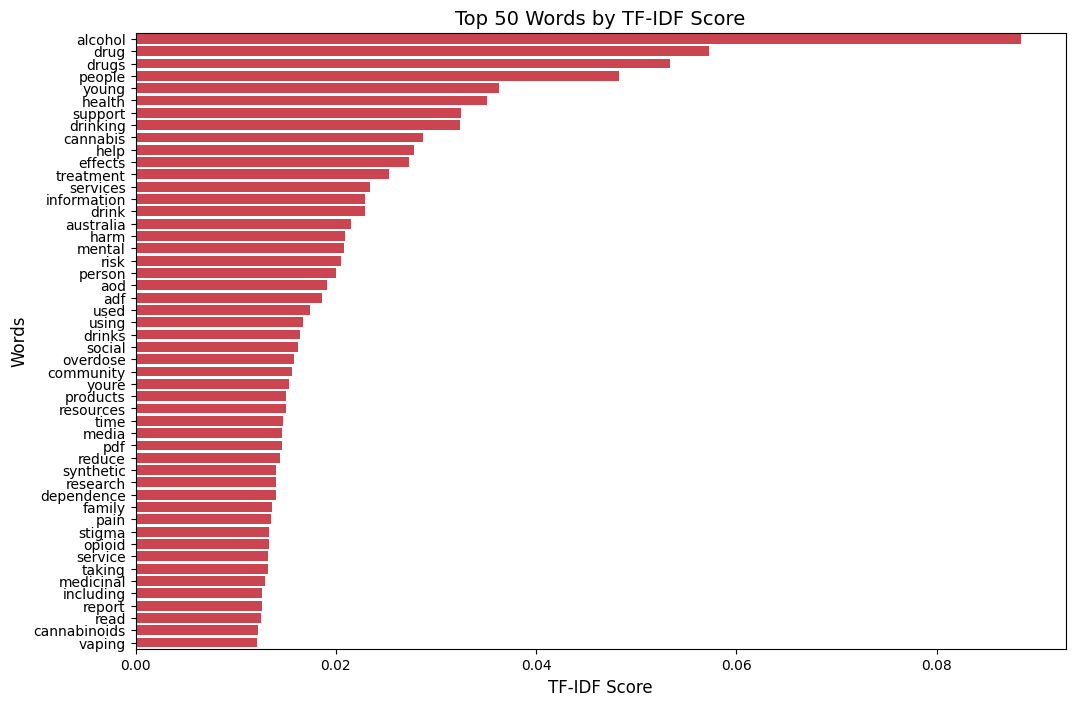

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS

# stop words list
stop_words_list = list(ENGLISH_STOP_WORDS) + ["2023", "2022", "2021", "2020", "2019", "like", "10", "use"]

tfidf = TfidfVectorizer(stop_words=stop_words_list)
tfidf.fit(cleaned_data['text'])

# top 50 words
feature_names = tfidf.get_feature_names_out()
tfidf_scores = tfidf.transform(cleaned_data['text'])
df_tfidf = pd.DataFrame(tfidf_scores.toarray(), columns=feature_names)
top_50_words = df_tfidf.mean().sort_values(ascending=False)[:50]

# Plot
plt.figure(figsize=(12, 8))
barplot = sns.barplot(x=top_50_words.values, y=top_50_words.index, color=secondary_colors[0])
plt.xlabel('TF-IDF Score', fontsize=12)
plt.ylabel('Words', fontsize=12)
plt.title('Top 50 Words by TF-IDF Score', fontsize=14, color=primary_colors[0])
plt.show()

##### Trends/ overuse of phrases - filtered out/ limited to reduce model bias

In [62]:
# # Create an instance of TfidfVectorizer and fit it on text field:
# stop_words_list = list(ENGLISH_STOP_WORDS)
# stop_words_list.append("2023")
# stop_words_list.append("2022")
# stop_words_list.append("2021")
# stop_words_list.append("2020")
# stop_words_list.append("2019")
# stop_words_list.append("like")
# stop_words_list.append("10")
# stop_words_list.append("use")

# tfidf = TfidfVectorizer(stop_words=stop_words_list)
# tfidf.fit(cleaned_data['text'])

# # Create a DataFrame for the top 50 words and their corresponding tf-idf scores:
# feature_names = tfidf.get_feature_names_out()
# tfidf_scores = tfidf.transform(cleaned_data['text'])
# df_tfidf = pd.DataFrame(tfidf_scores.toarray(), columns=feature_names)
# top_50_words = df_tfidf.mean().sort_values(ascending=False)[:50]

# # Plot the tf-idf scores using Seaborn:
# plt.figure(figsize=(12, 8))
# sns.barplot(x=top_50_words.values, y=top_50_words.index, color='Blue')
# plt.xlabel('TF-IDF Score', fontsize=12)
# plt.ylabel('Words', fontsize=12)
# plt.title('Top 50 Words by TF-IDF Score', fontsize=14)
# plt.show()

In [63]:
cleaned_data['url_reduced'].nunique()

33

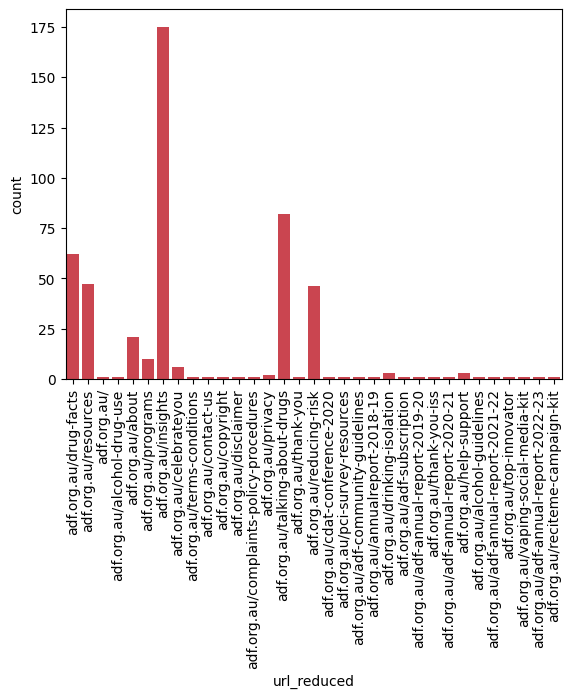

In [64]:
sns.countplot(x='url_reduced', data=cleaned_data, color=red)
plt.xticks(rotation=90)
plt.show()

In [65]:
category_counts = cleaned_data['url_reduced'].value_counts()
print(category_counts)

adf.org.au/insights                        175
adf.org.au/talking-about-drugs              82
adf.org.au/drug-facts                       62
adf.org.au/resources                        47
adf.org.au/reducing-risk                    46
adf.org.au/about                            21
adf.org.au/programs                         10
adf.org.au/celebrateyou                      6
adf.org.au/drinking-isolation                3
adf.org.au/help-support                      3
adf.org.au/privacy                           2
adf.org.au/adf-annual-report-2022-23         1
adf.org.au/vaping-social-media-kit           1
adf.org.au/top-innovator                     1
adf.org.au/adf-annual-report-2021-22         1
adf.org.au/alcohol-guidelines                1
adf.org.au/adf-annual-report-2020-21         1
adf.org.au/thank-you-iss                     1
adf.org.au/adf-annual-report-2019-20         1
adf.org.au/adf-subscription                  1
adf.org.au/adf-community-guidelines          1
adf.org.au/an

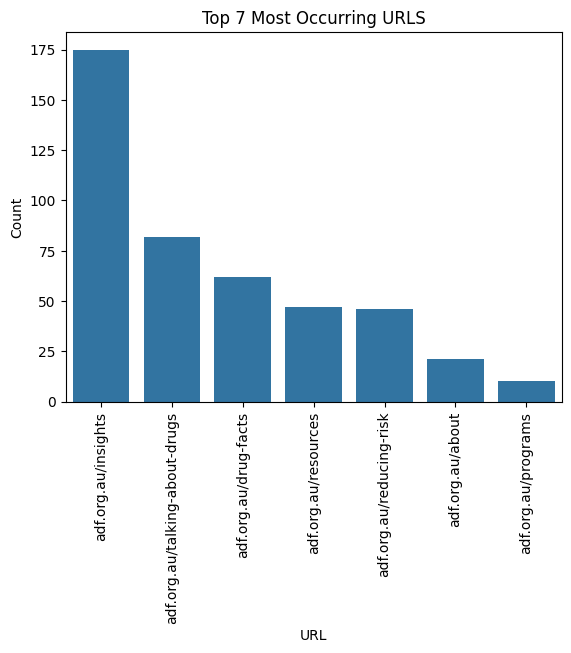

In [66]:
category_counts = cleaned_data['url_reduced'].value_counts().head(7)
sns.barplot(x=category_counts.index, y=category_counts.values)
plt.xticks(rotation=90)
plt.xlabel('URL')
plt.ylabel('Count')
plt.title('Top 7 Most Occurring URLS')
plt.show()

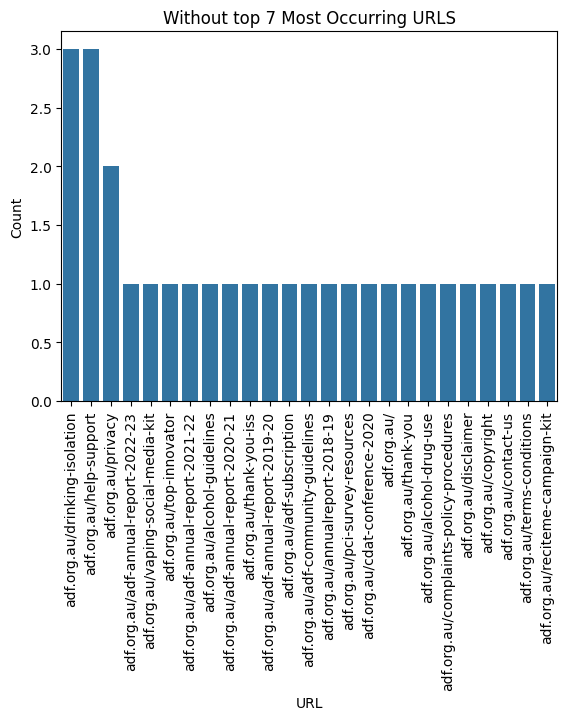

In [67]:
category_counts = cleaned_data['url_reduced'].value_counts().tail(25)
sns.barplot(x=category_counts.index, y=category_counts.values)
plt.xticks(rotation=90)
plt.xlabel('URL')
plt.ylabel('Count')
plt.title('Without top 7 Most Occurring URLS')
plt.show()

In [68]:
# Show max width of columns in Google Collab ->
pd.set_option('display.max_colwidth', None)

#####Newest Modified URL
#### reduced_wc_gc_data['last_updated']

In [69]:
# Sort 'last_updated' in descending order to get the most recent dates first
sorted_data = cleaned_data.sort_values(by='last_updated', ascending=False)

# Select the most recently updated record
most_recently_updated_url = sorted_data.iloc[0]
print(most_recently_updated_url[['url', 'last_updated']])

url             https://adf.org.au/talking-about-drugs/parenting-talk/teenagers-aod-use/teenagers-and-alcohol/teens-campaign-kit/
last_updated                                                                                                  2024-01-23 00:00:00
Name: 326, dtype: object


#####Latest 50 updated URLs
#### reduced_wc_gc_data['last_updated']

In [70]:
# Top 50 most recently updated records
latest_50_updated_urls = sorted_data.head(50)
print(latest_50_updated_urls[['url', 'last_updated']])

# Save data
data_path = '/content/drive/MyDrive/ADFAIChatbot/output_stats/latest_50_updated_urls.csv'
latest_50_updated_urls.to_csv(data_path, index=False)
print('Saved output /content/drive/MyDrive/ADFAIChatbot/output_stats/latest_50_updated_urls.csv')

                                                                                                                   url  \
326  https://adf.org.au/talking-about-drugs/parenting-talk/teenagers-aod-use/teenagers-and-alcohol/teens-campaign-kit/   
52                                               https://adf.org.au/alcohol-drug-use/supporting-a-loved-one/treatment/   
248                                                           https://adf.org.au/insights/dementia-alcohol-connection/   
455                     https://adf.org.au/drinking-isolation/why-we-need-talk-about-parents-drinking-during-lockdown/   
293                                                             https://adf.org.au/insights/prescription-meds-alcohol/   
292                                                            https://adf.org.au/insights/residential-rehabilitation/   
279                                                                      https://adf.org.au/insights/clearing-the-air/   
275                     

#####Oldest 50 updated URLs
#### reduced_wc_gc_data['last_updated']

In [71]:
sorted_data = cleaned_data.sort_values(by='last_updated') # ascending order
oldest_50_updated_urls = sorted_data.head(50)
print(oldest_50_updated_urls[['url', 'last_updated']])

# Save data
data_path = '/content/drive/MyDrive/ADFAIChatbot/output_stats/oldest_50_updated_urls.csv'
oldest_50_updated_urls.to_csv(data_path, index=False)
print('Saved output /content/drive/MyDrive/ADFAIChatbot/output_stats/oldest_50_updated_urls.csv')

                                                                                                                                                                                                                                                              url  \
312                                                                                                                                                                                                                          https://adf.org.au/terms-conditions/   
168                                                                                                                                                                                                             https://adf.org.au/insights/rescheduling-codeine/   
318                                                                                                                                                                                                                      

### Temporal Trends (last updated)
*   Number of records for each year
*   Category counts per year
*   Category published the most
*   Category published the most (per year)

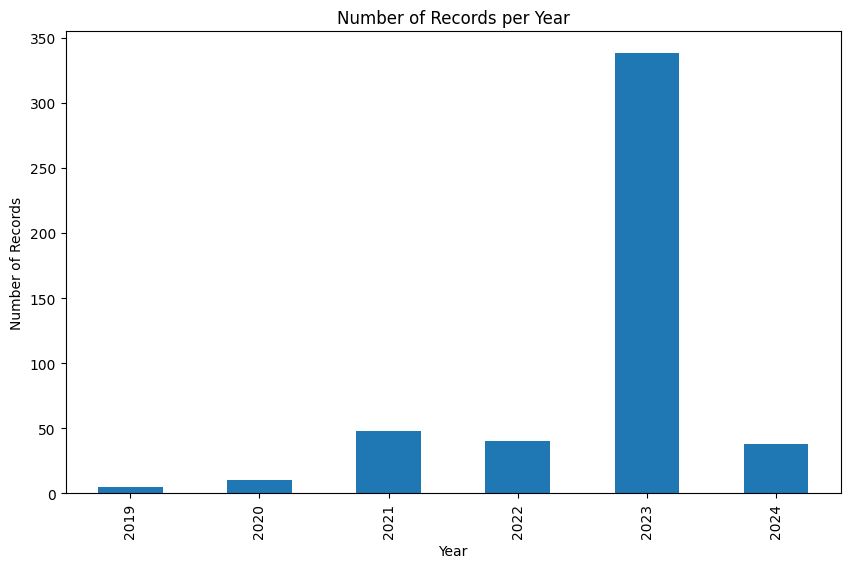

In [72]:
# Number of records for each year (last updated)
# Find year and count
cleaned_data['last_updated'] = pd.to_datetime(cleaned_data['last_updated'])
cleaned_data['year'] = cleaned_data['last_updated'].dt.year
records_per_year = cleaned_data.groupby('year').size()

# Plot
plt.figure(figsize=(10, 6))
records_per_year.plot(kind='bar')
plt.xlabel('Year')
plt.ylabel('Number of Records')
plt.title('Number of Records per Year')
plt.show()

In [73]:
# Category counts per year
category_counts_per_year = cleaned_data.groupby(['year', 'url_reduced']).size().reset_index(name='counts')
print(category_counts_per_year)

# Save data
data_path = '/content/drive/MyDrive/ADFAIChatbot/output_stats/category_counts_per_year.csv'
category_counts_per_year.to_csv(data_path, index=False)
print('Saved output /content/drive/MyDrive/ADFAIChatbot/output_stats/category_counts_per_year.csv')

    year                              url_reduced  counts
0   2019                      adf.org.au/insights       2
1   2019                       adf.org.au/privacy       1
2   2019              adf.org.au/terms-conditions       1
3   2019                     adf.org.au/thank-you       1
4   2020      adf.org.au/adf-community-guidelines       1
5   2020                  adf.org.au/celebrateyou       2
6   2020                      adf.org.au/insights       5
7   2020          adf.org.au/pci-survey-resources       1
8   2020                     adf.org.au/resources       1
9   2021                         adf.org.au/about       1
10  2021     adf.org.au/adf-annual-report-2020-21       1
11  2021          adf.org.au/cdat-conference-2020       1
12  2021                    adf.org.au/drug-facts       1
13  2021                  adf.org.au/help-support       1
14  2021                      adf.org.au/insights      14
15  2021                      adf.org.au/programs       1
16  2021      

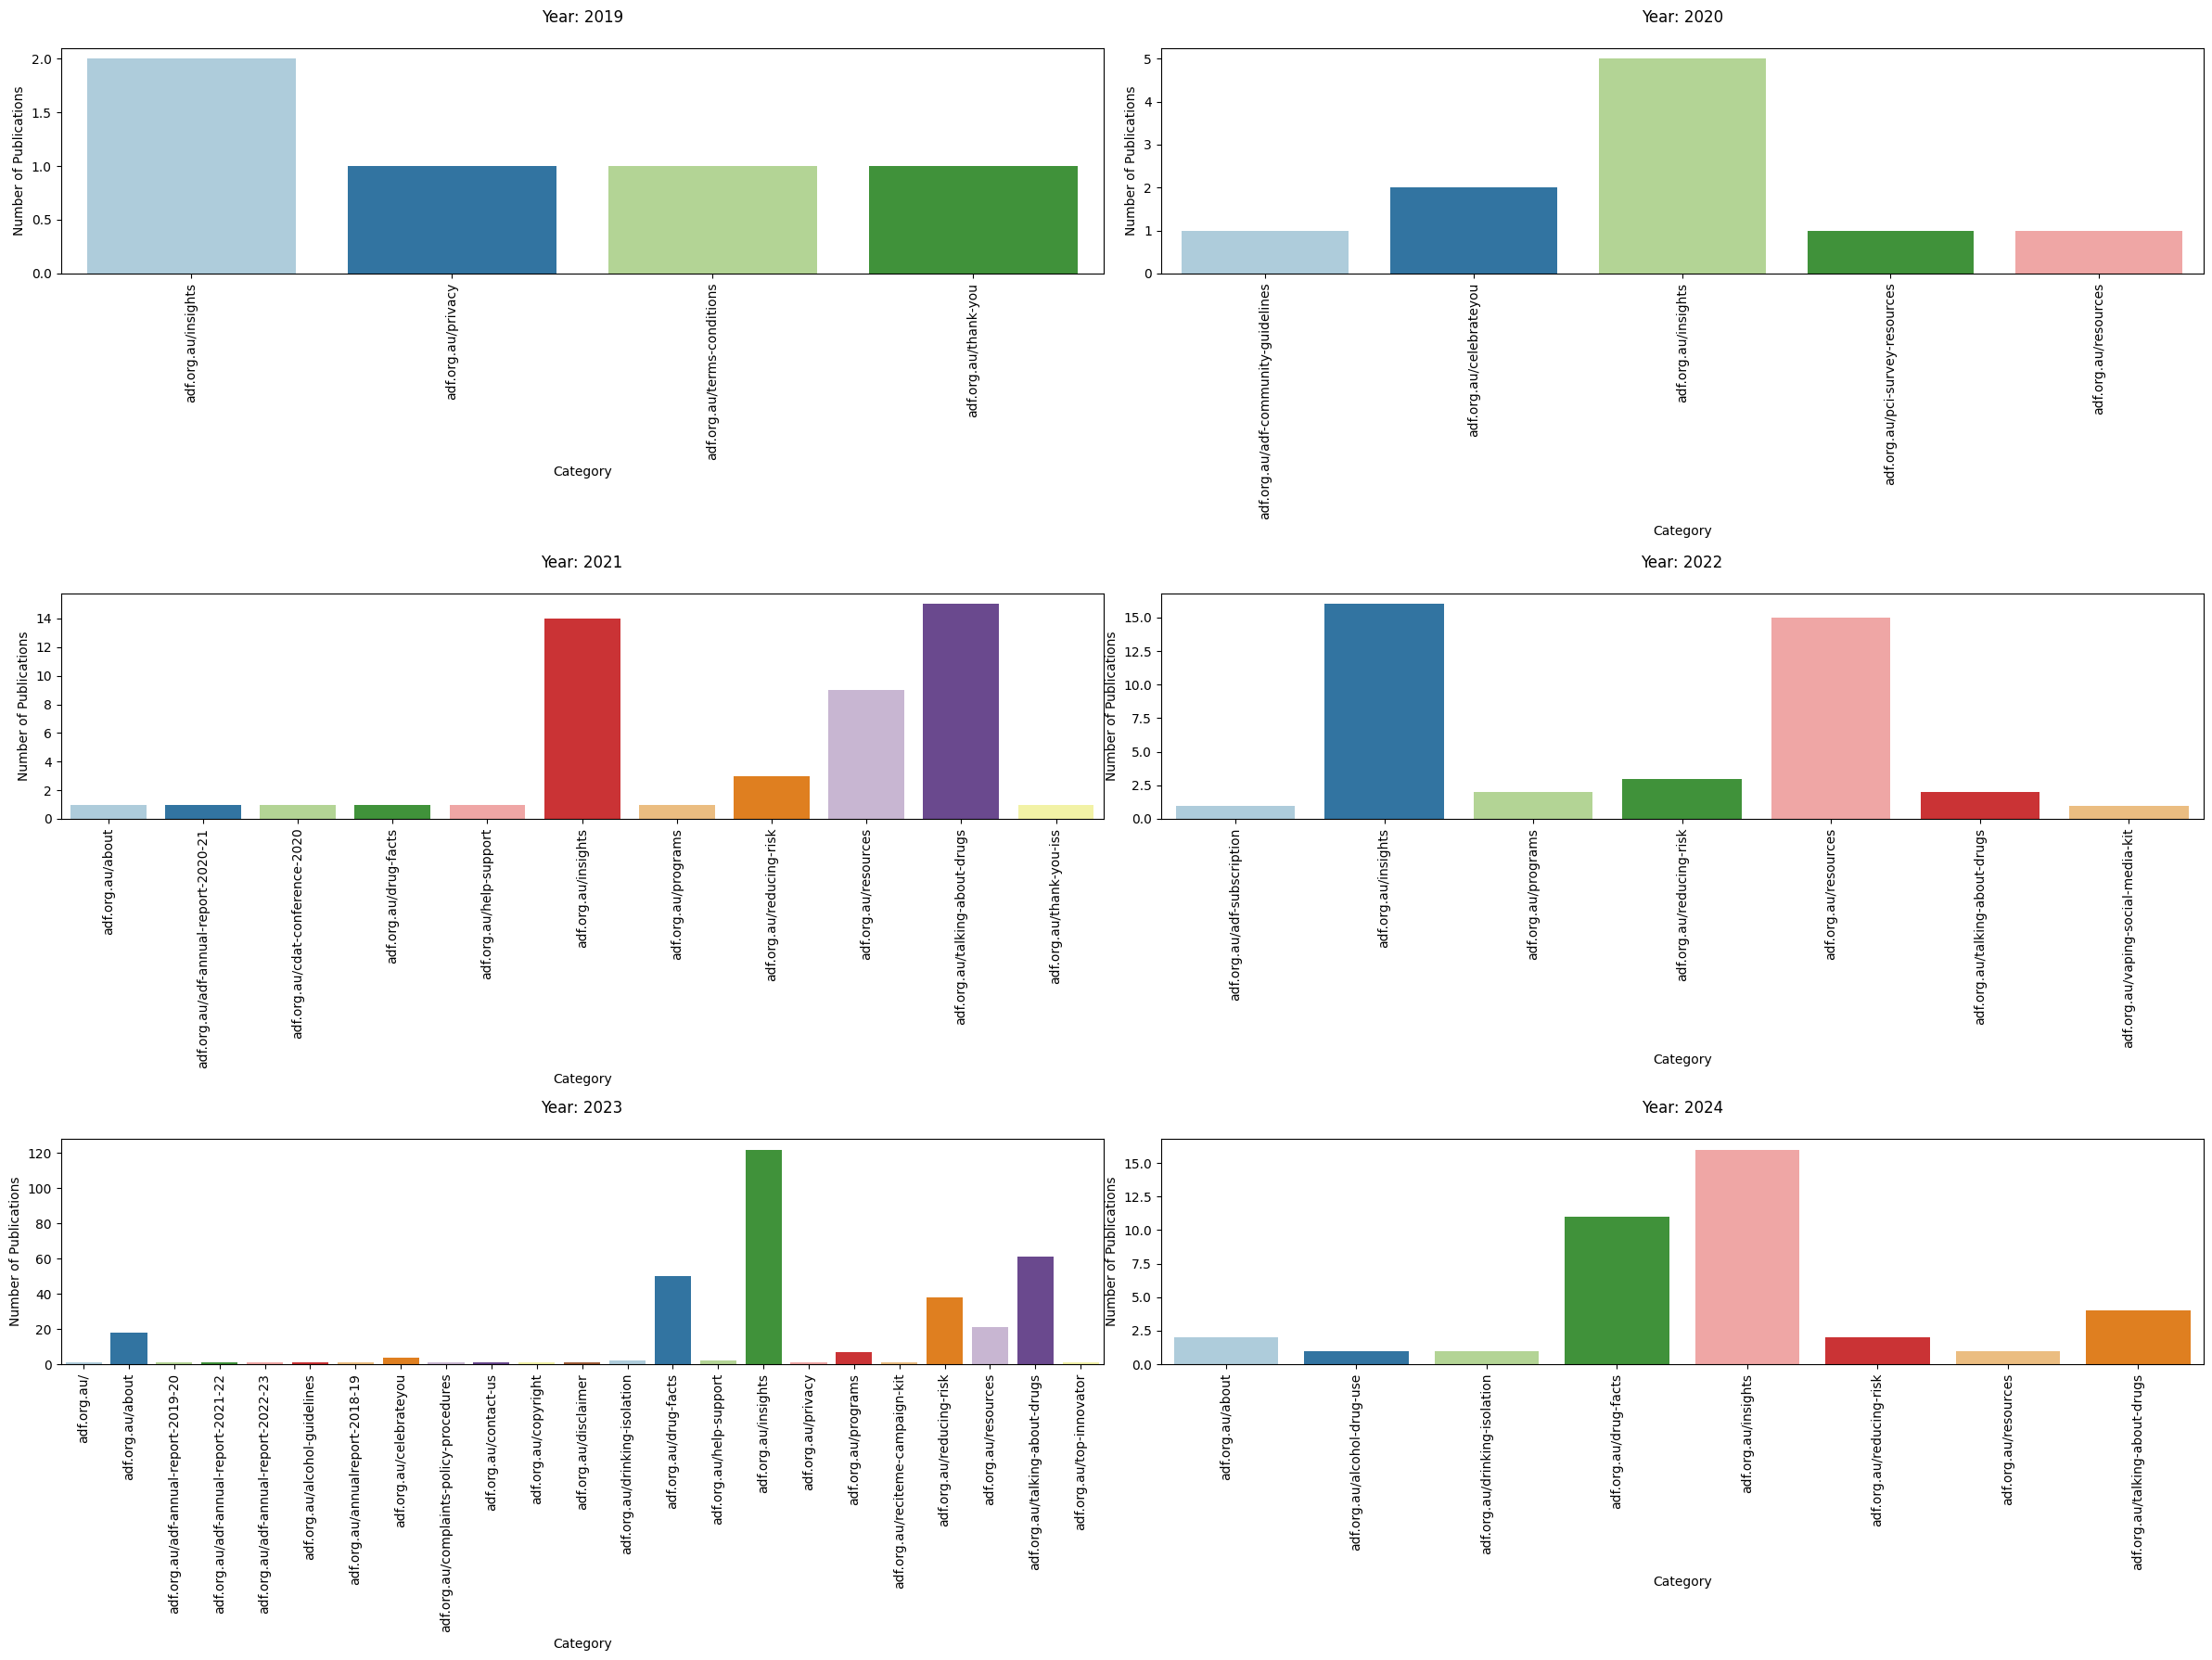

In [74]:
# Category counts per year (plot)
unique_years = category_counts_per_year['year'].unique()

# Layout
n_rows = (len(unique_years) + 1) // 2
n_cols = 2
fig, axs = plt.subplots(n_rows, n_cols, figsize=(12 * n_cols, 6 * n_rows))
axs = axs.flatten()

# Barplot for each year
for i, year in enumerate(unique_years):
    # Filter data for the year
    year_data = category_counts_per_year[category_counts_per_year['year'] == year]

    # Adjust color
    unique_categories = year_data['url_reduced'].nunique()
    palette = sns.color_palette('Paired', unique_categories)

    # Subplots
    sns.barplot(x='url_reduced', y='counts', hue='url_reduced', data=year_data,
                ax=axs[i], dodge=False, legend=False, palette=palette)
    axs[i].set_title(f"Year: {year}", pad=20)
    axs[i].set_xlabel('Category')
    axs[i].set_ylabel('Number of Publications')
    axs[i].tick_params(axis='x', rotation=90)

if len(unique_years) % 2 != 0:
    axs[-1].axis('off') # If odd years

plt.tight_layout()
plt.show()

In [75]:
# Category published the most
category_counts = cleaned_data['url_reduced'].value_counts()
most_published_category = category_counts.idxmax()
most_published_count = category_counts.max()
print(f"The most published category is '{most_published_category}' with {most_published_count} publications.")

The most published category is 'adf.org.au/insights' with 175 publications.


In [76]:
# Category published the most (per year)
most_published_per_year = category_counts_per_year.loc[category_counts_per_year.groupby('year')['counts'].idxmax()]
print(most_published_per_year)

    year                     url_reduced  counts
0   2019             adf.org.au/insights       2
6   2020             adf.org.au/insights       5
18  2021  adf.org.au/talking-about-drugs      15
21  2022             adf.org.au/insights      16
42  2023             adf.org.au/insights     122
54  2024             adf.org.au/insights      16


### Content Analysis
*   Text Length Distribution
*   Word Clouds


##### Text Length Distribution
*   Analyse the distribution of text lengths (number of words or characters) in the text column.
*   Provides insights into the depth of ADF content provided in different resources.

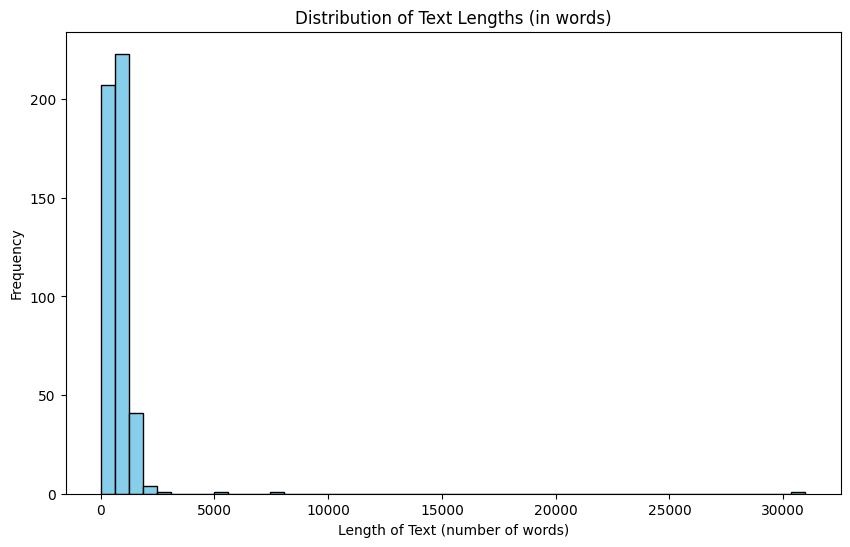

In [77]:
# Distribution of Text Lengths (in words) plot histogram
# Check non-string or missing values
cleaned_data['text'] = cleaned_data['text'].fillna('').astype(str)

# Calculate the length of each text (in words)
cleaned_data['text_length'] = cleaned_data['text'].apply(lambda x: len(x.split()))

# Plot
plt.figure(figsize=(10, 6))
plt.hist(cleaned_data['text_length'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Text Lengths (in words)')
plt.xlabel('Length of Text (number of words)')
plt.ylabel('Frequency')
plt.show()

##### Top Domains Text Length

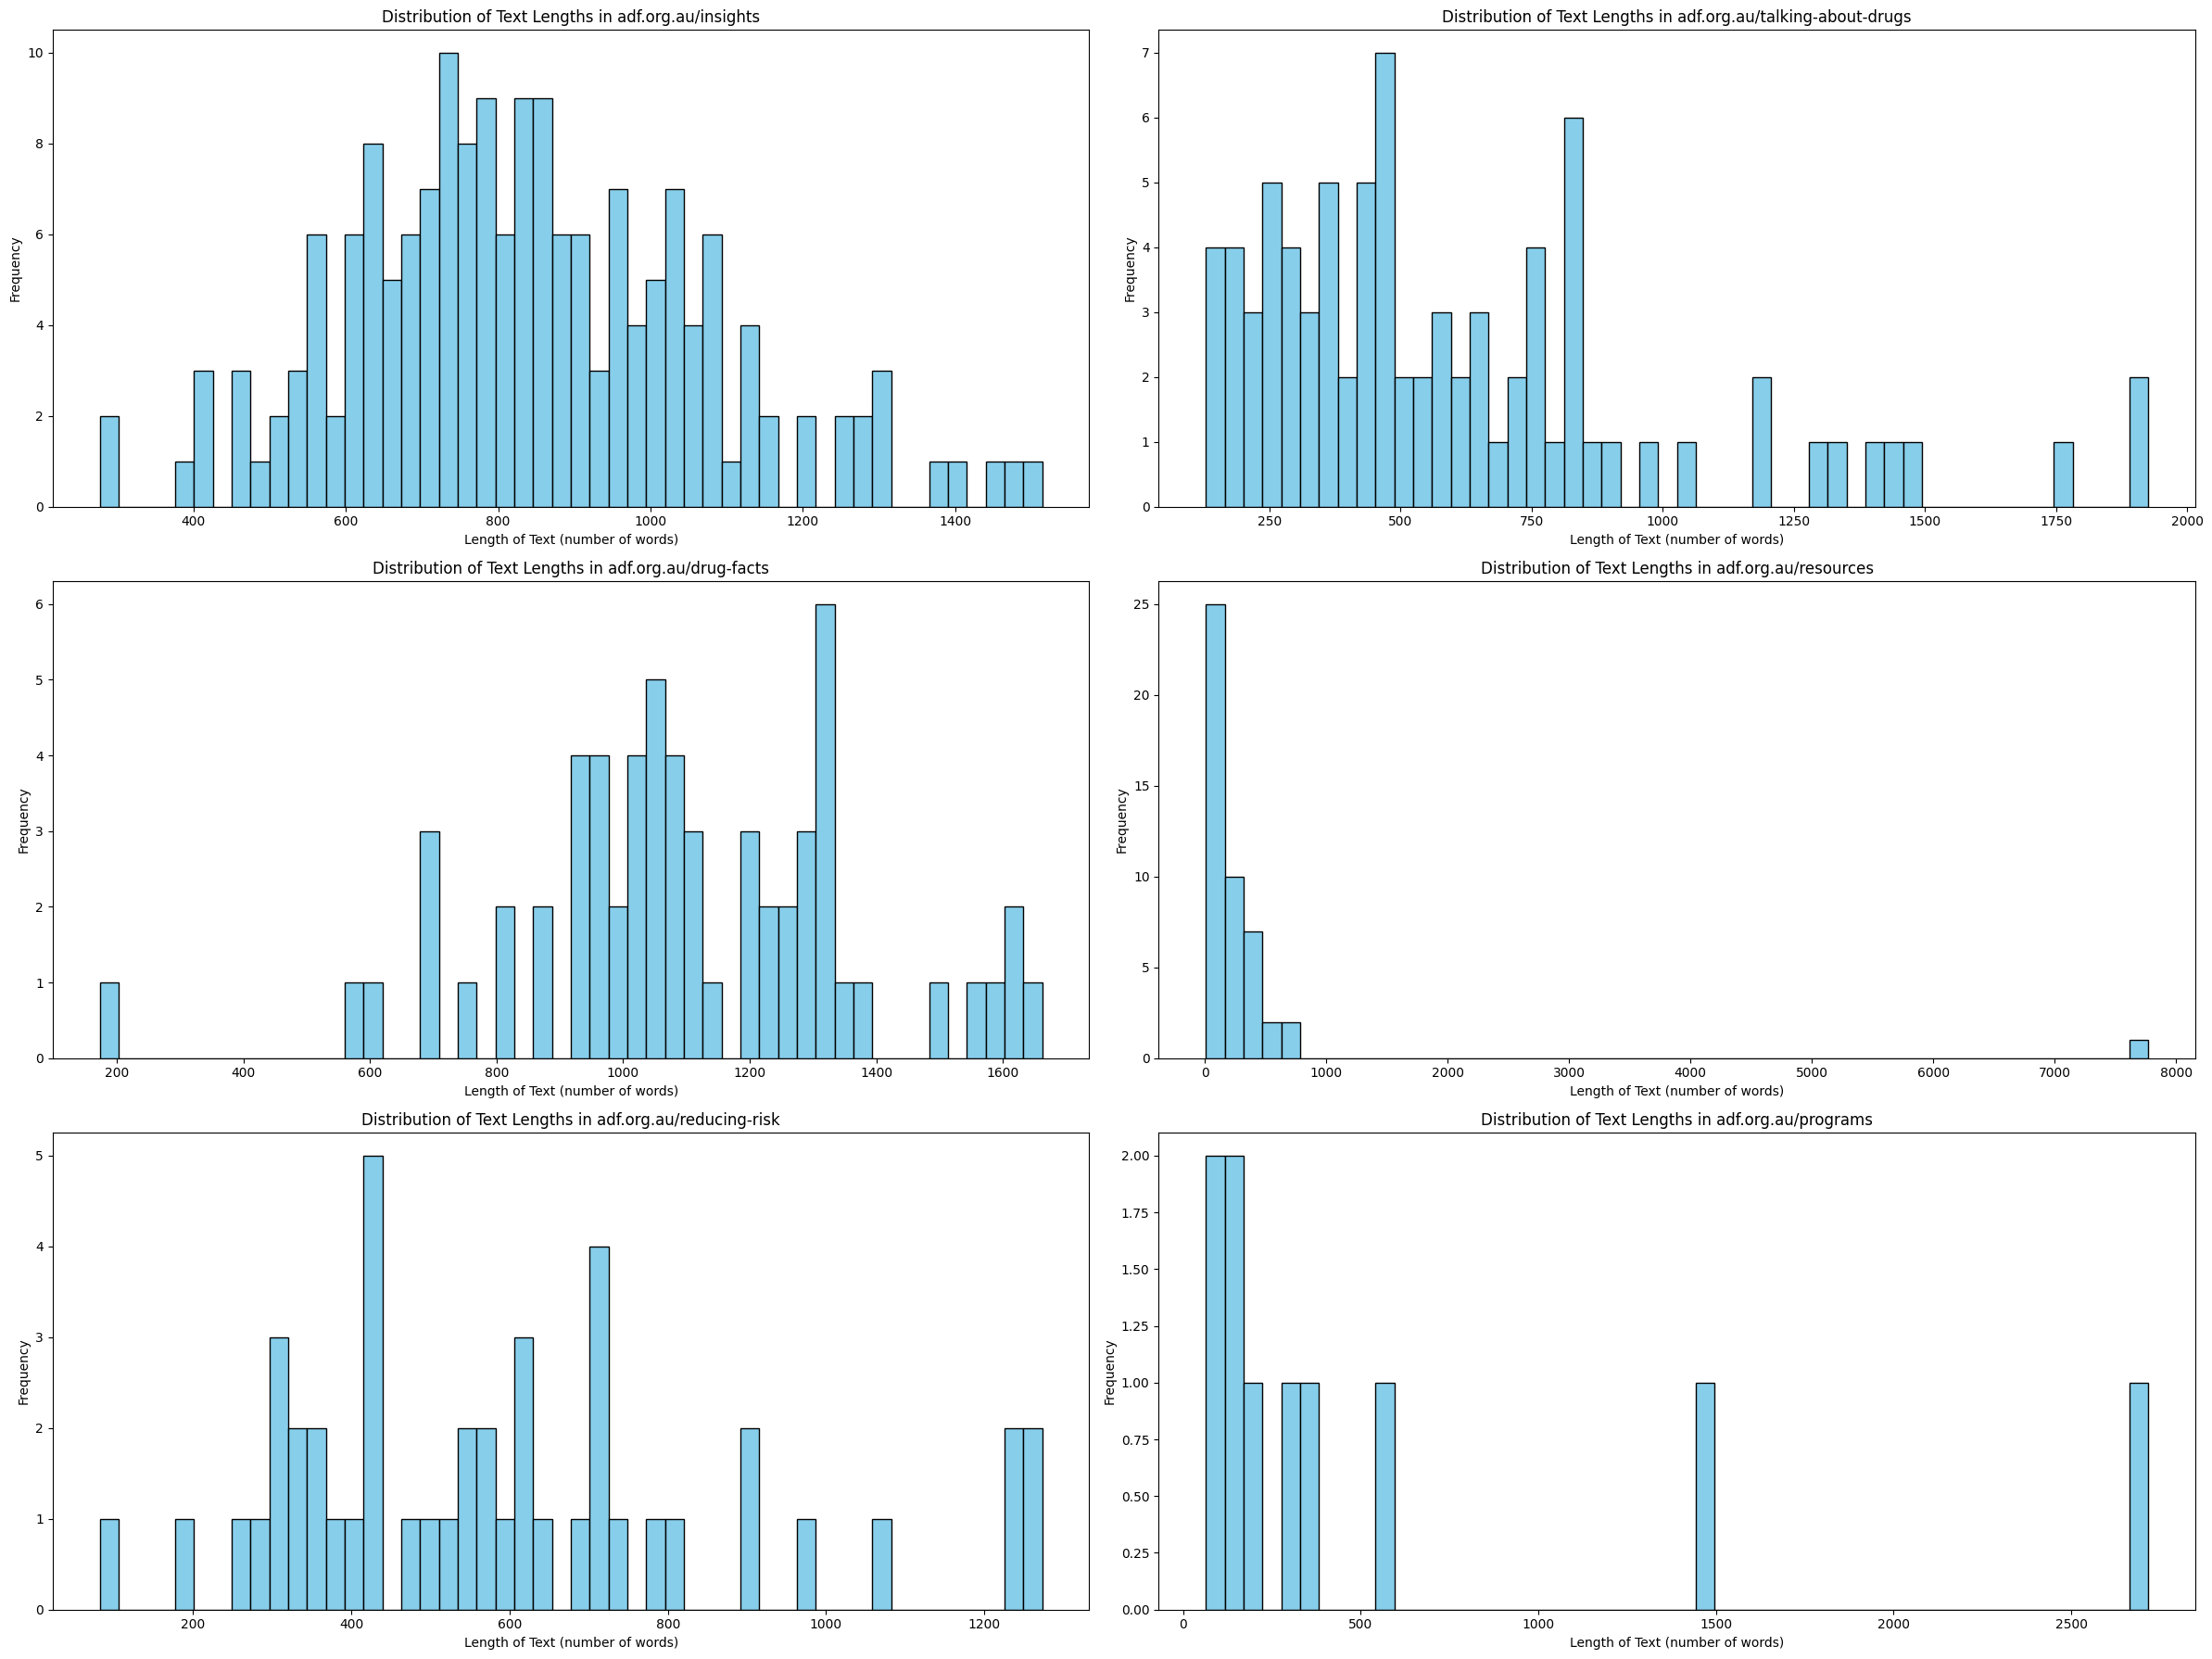

In [78]:
# Top Domains Text Length
top_domains = [
    'adf.org.au/insights',
    'adf.org.au/talking-about-drugs',
    'adf.org.au/drug-facts',
    'adf.org.au/resources',
    'adf.org.au/reducing-risk',
    'adf.org.au/programs'
]

# Calculate word length
cleaned_data['text_length'] = cleaned_data['text'].fillna('').apply(lambda x: len(x.split()))

# Layout
n_domains = len(top_domains)
n_cols = 2
n_rows = n_domains // n_cols + (n_domains % n_cols > 0)

# Subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(12 * n_cols, 6 * n_rows))
axs = axs.flatten()

# Plot domain histograms
for i, domain in enumerate(top_domains):
    domain_data = cleaned_data[cleaned_data['url_reduced'].str.contains(domain)]

    # Plot
    axs[i].hist(domain_data['text_length'], bins=50, color='skyblue', edgecolor='black')
    axs[i].set_title(f'Distribution of Text Lengths in {domain}')
    axs[i].set_xlabel('Length of Text (number of words)')
    axs[i].set_ylabel('Frequency')

for j in range(i + 1, n_rows * n_cols):
    axs[j].axis('off')
plt.tight_layout()
plt.show()


##### Word Clouds
*   Generate word clouds for the text, title, and description columns to visualise the most frequently occurring words.
*   Helps in understanding the main focus areas of the ADF content.


##### List of stop words
'and', 'the', 'of', 'to', 'in', 'a', 'for', 'on', 'is', 'its', 'use', 'with', 'about', 'or', 'other', 'covid19'

In [79]:
# Define list of stop words
stop_words_list = list(ENGLISH_STOP_WORDS)
stop_words_list.extend(["2023", "2022", "2021", "2020", "2019", "like", "10", "use", "and", "the", "of", "to", "in", "a", "for", "on", "is", "its", "with", "about", "or", "other", "covid19"])

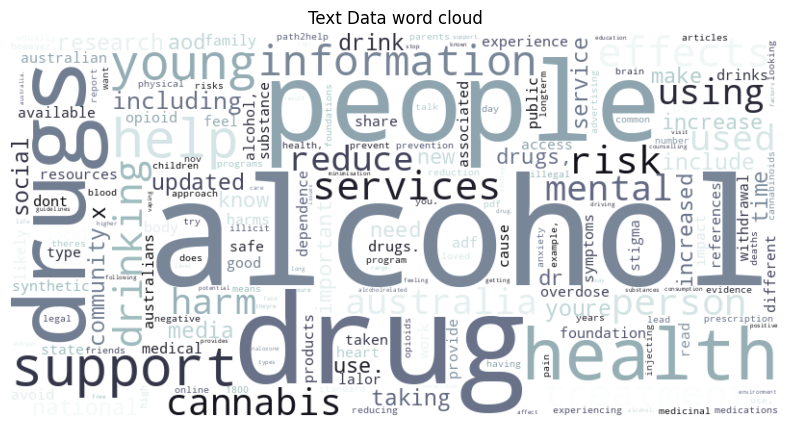

alcohol: 4628
drug: 3092
people: 2423
drugs: 1816
health: 1529
support: 1213
help: 1191
young: 1002
information: 916
effects: 886
drinking: 785
services: 767
risk: 747
treatment: 740
person: 697
cannabis: 671
australia: 649
used: 642
harm: 636
mental: 633


In [80]:
# Combine text remove stop words
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
text_combined = " ".join(cleaned_data['text'].dropna())
words = text_combined.split()
filtered_words = [word for word in words if word.lower() not in stop_words_list]
filtered_text = " ".join(filtered_words)

# Word frequencies
word_freq = Counter(filtered_words)
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='bone').generate_from_frequencies(word_freq)

# Plot
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Text Data word cloud')
plt.show()

# Word frequencies
for word, freq in word_freq.most_common(20):  # 20 most common words
    print(f"{word}: {freq}")


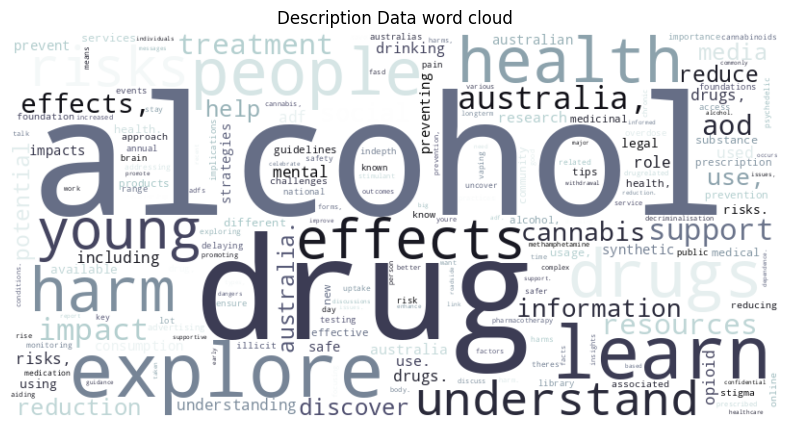

alcohol: 181
drug: 129
explore: 58
learn: 55
drugs: 44
people: 43
health: 41
harm: 39
effects: 36
young: 36
risks: 35
understand: 32
australia,: 30
impact: 29
support: 28
treatment: 26
resources: 26
aod: 25
effects,: 24
cannabis: 23


In [81]:
# Combine description and remove stop words
description_combined = " ".join(cleaned_data['description'].dropna())
words = description_combined.split()
filtered_words = [word for word in words if word.lower() not in stop_words_list]

# Calculate word frequencies using filtered words
word_freq = Counter(filtered_words)

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='bone').generate_from_frequencies(word_freq)

# Plot
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Description Data word cloud')
plt.show()

# Print word frequencies
for word, freq in word_freq.most_common(20):  # 20 most common words
    print(f"{word}: {freq}")

##### Top Domain Word Clouds
##### Top domains
*   adf.org.au/insights                        176
*   adf.org.au/talking-about-drugs              81
*   adf.org.au/drug-facts                       62
*   adf.org.au/resources                        49
*   adf.org.au/reducing-risk                    46
*   adf.org.au/programs                         24

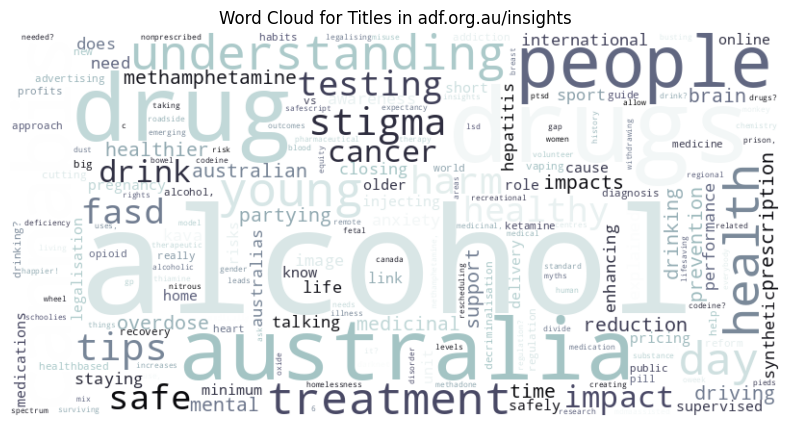

alcohol: 54
drugs: 21
drug: 17
australia: 14
cannabis: 12
people: 10
understanding: 8
health: 8
young: 8
day: 7
treatment: 7
stigma: 5
tips: 5
harm: 5
safe: 4
fasd: 4
testing: 4
healthy: 4
impact: 3
drink: 3


In [82]:
filtered_data = cleaned_data[cleaned_data['url_reduced'].str.contains('adf.org.au/insights', na=False)]
titles_combined = " ".join(filtered_data['title'].dropna())

# Split titles into words and filter
words = titles_combined.split()
filtered_words = [word for word in words if word.lower() not in stop_words_list]

# Calculate word frequencies
title_word_freq = Counter(filtered_words)
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='bone').generate_from_frequencies(title_word_freq)

# Plot
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Titles in adf.org.au/insights')
plt.show()

# Print word frequencies
for word, freq in title_word_freq.most_common(20):  # 20 most common words
    print(f"{word}: {freq}")


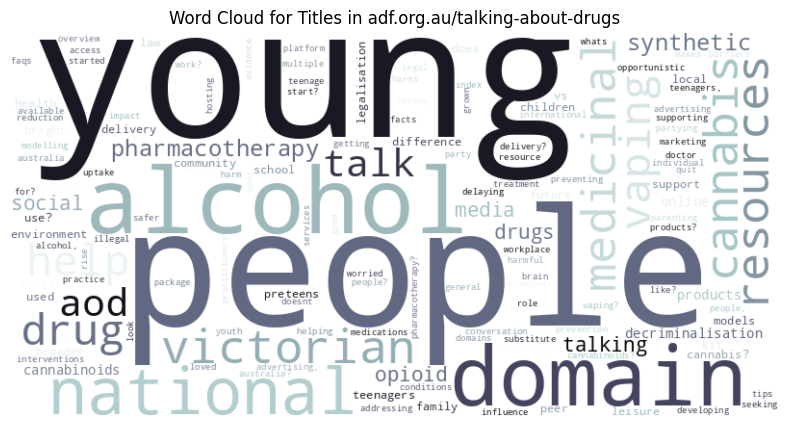

young: 20
people: 16
alcohol: 10
domain: 8
national: 6
victorian: 6
resources: 6
medicinal: 6
cannabis: 6
drug: 5
help: 5
vaping: 5
talk: 4
aod: 4
pharmacotherapy: 4
synthetic: 4
talking: 3
drugs: 3
social: 3
media: 3


In [83]:
# Word Cloud for Titles in adf.org.au/talking-about-drugs
filtered_data = cleaned_data[cleaned_data['url_reduced'].str.contains('adf.org.au/talking-about-drugs', na=False)]
titles_combined = " ".join(filtered_data['title'].dropna())

# Split titles into words and filter
words = titles_combined.split()
filtered_words = [word for word in words if word.lower() not in stop_words_list]

# Calculate word frequencies
title_word_freq = Counter(filtered_words)
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='bone').generate_from_frequencies(title_word_freq)

# Plot
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Titles in adf.org.au/talking-about-drugs')
plt.show()

# Print word frequencies
for word, freq in title_word_freq.most_common(20):  # 20 most common words
    print(f"{word}: {freq}")


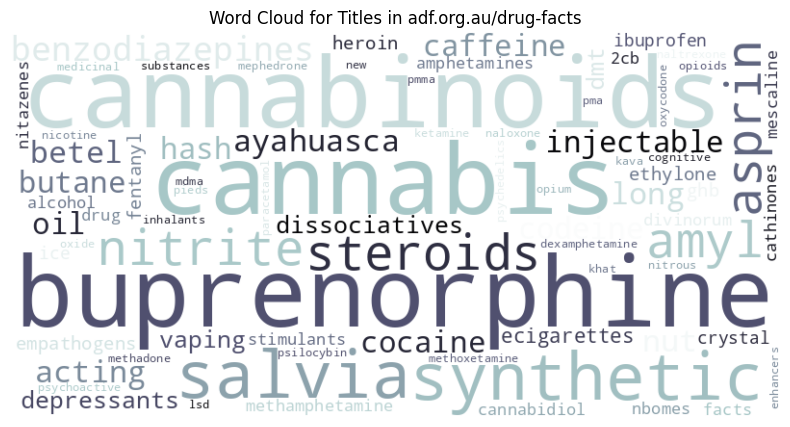

buprenorphine: 2
cannabinoids: 2
cannabis: 2
synthetic: 2
salvia: 2
amyl: 1
nitrite: 1
steroids: 1
asprin: 1
benzodiazepines: 1
ayahuasca: 1
betel: 1
nut: 1
long: 1
acting: 1
injectable: 1
butane: 1
hash: 1
oil: 1
caffeine: 1


In [84]:
# Word Cloud for Titles in adf.org.au/drug-facts
filtered_data = cleaned_data[cleaned_data['url_reduced'].str.contains('adf.org.au/drug-facts', na=False)]
titles_combined = " ".join(filtered_data['title'].dropna())

# Split titles into words and filter
words = titles_combined.split()
filtered_words = [word for word in words if word.lower() not in stop_words_list]

# Calculate word frequencies
title_word_freq = Counter(filtered_words)
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='bone').generate_from_frequencies(title_word_freq)

# Plot
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Titles in adf.org.au/drug-facts')
plt.show()

# Print word frequencies
for word, freq in title_word_freq.most_common(20):  # 20 most common words
    print(f"{word}: {freq}")


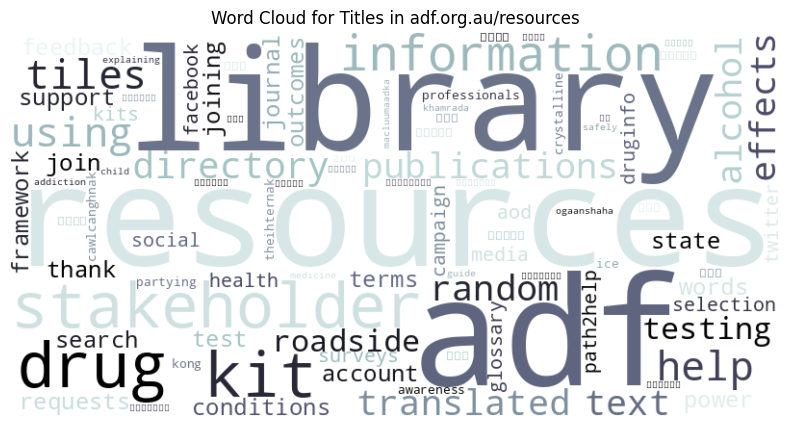

adf: 8
library: 7
resources: 7
stakeholder: 4
kit: 4
drug: 4
information: 3
help: 2
using: 2
tiles: 2
directory: 2
publications: 2
translated: 2
text: 2
effects: 2
alcohol: 2
random: 2
roadside: 2
testing: 2
support: 1


In [85]:
# Word Cloud for Titles in adf.org.au/resources
filtered_data = cleaned_data[cleaned_data['url_reduced'].str.contains('adf.org.au/resources', na=False)]
titles_combined = " ".join(filtered_data['title'].dropna())

# Split titles into words and filter
words = titles_combined.split()
filtered_words = [word for word in words if word.lower() not in stop_words_list]

# Calculate word frequencies
title_word_freq = Counter(filtered_words)
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='bone').generate_from_frequencies(title_word_freq)

# Plot
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Titles in adf.org.au/resources')
plt.show()

# Print word frequencies
for word, freq in title_word_freq.most_common(20):  # 20 most common words
    print(f"{word}: {freq}")


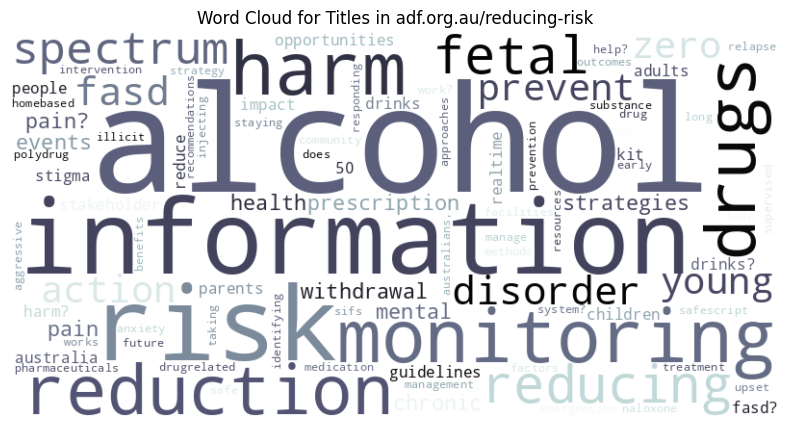

alcohol: 8
risk: 3
information: 3
monitoring: 3
harm: 3
reduction: 3
drugs: 3
reducing: 2
fetal: 2
spectrum: 2
disorder: 2
fasd: 2
prevent: 2
action: 2
zero: 2
young: 2
prescription: 2
chronic: 2
pain?: 2
pain: 2


In [86]:
# Word Cloud for Titles in adf.org.au/reducing-risk
filtered_data = cleaned_data[cleaned_data['url_reduced'].str.contains('adf.org.au/reducing-risk', na=False)]
titles_combined = " ".join(filtered_data['title'].dropna())

# Split titles into words and filter
words = titles_combined.split()
filtered_words = [word for word in words if word.lower() not in stop_words_list]

# Calculate word frequencies
title_word_freq = Counter(filtered_words)
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='bone').generate_from_frequencies(title_word_freq)

# Plot
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Titles in adf.org.au/reducing-risk')
plt.show()

# Print word frequencies
for word, freq in title_word_freq.most_common(20):  # 20 most common words
    print(f"{word}: {freq}")


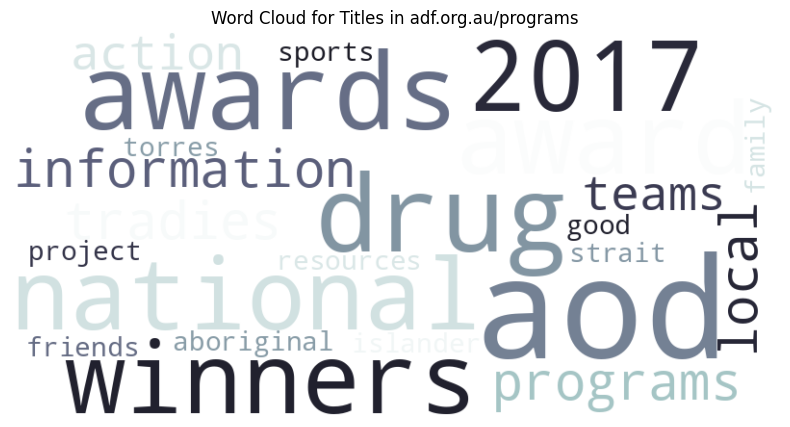

aod: 4
drug: 2
awards: 2
national: 2
award: 2
winners: 2
2017: 2
information: 1
tradies: 1
programs: 1
local: 1
action: 1
teams: 1
aboriginal: 1
torres: 1
strait: 1
islander: 1
resources: 1
good: 1
sports: 1


In [87]:
# Word Cloud for Titles in adf.org.au/programs
filtered_data = cleaned_data[cleaned_data['url_reduced'].str.contains('adf.org.au/programs', na=False)]
titles_combined = " ".join(filtered_data['title'].dropna())

# Split titles into words and filter
words = titles_combined.split()
filtered_words = [word for word in words if word.lower() not in stop_words_list]

# Calculate word frequencies
title_word_freq = Counter(filtered_words)
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='bone').generate_from_frequencies(title_word_freq)

# Plot
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Titles in adf.org.au/programs')
plt.show()

# Print word frequencies
for word, freq in title_word_freq.most_common(20):  # 20 most common words
    print(f"{word}: {freq}")



##LDA Topic Modelling
**What is topic modeling?**

Topic modeling is a method for unsupervised classification of documents, similar to clustering on numeric data, which finds some natural groups of items (topics) even when we’re not sure what we’re looking for.


**Results:**
Since LDA is an unsupervised classification of documents, it doesn't


References


https://towardsdatascience.com/latent-dirichlet-allocation-lda-9d1cd064ffa2

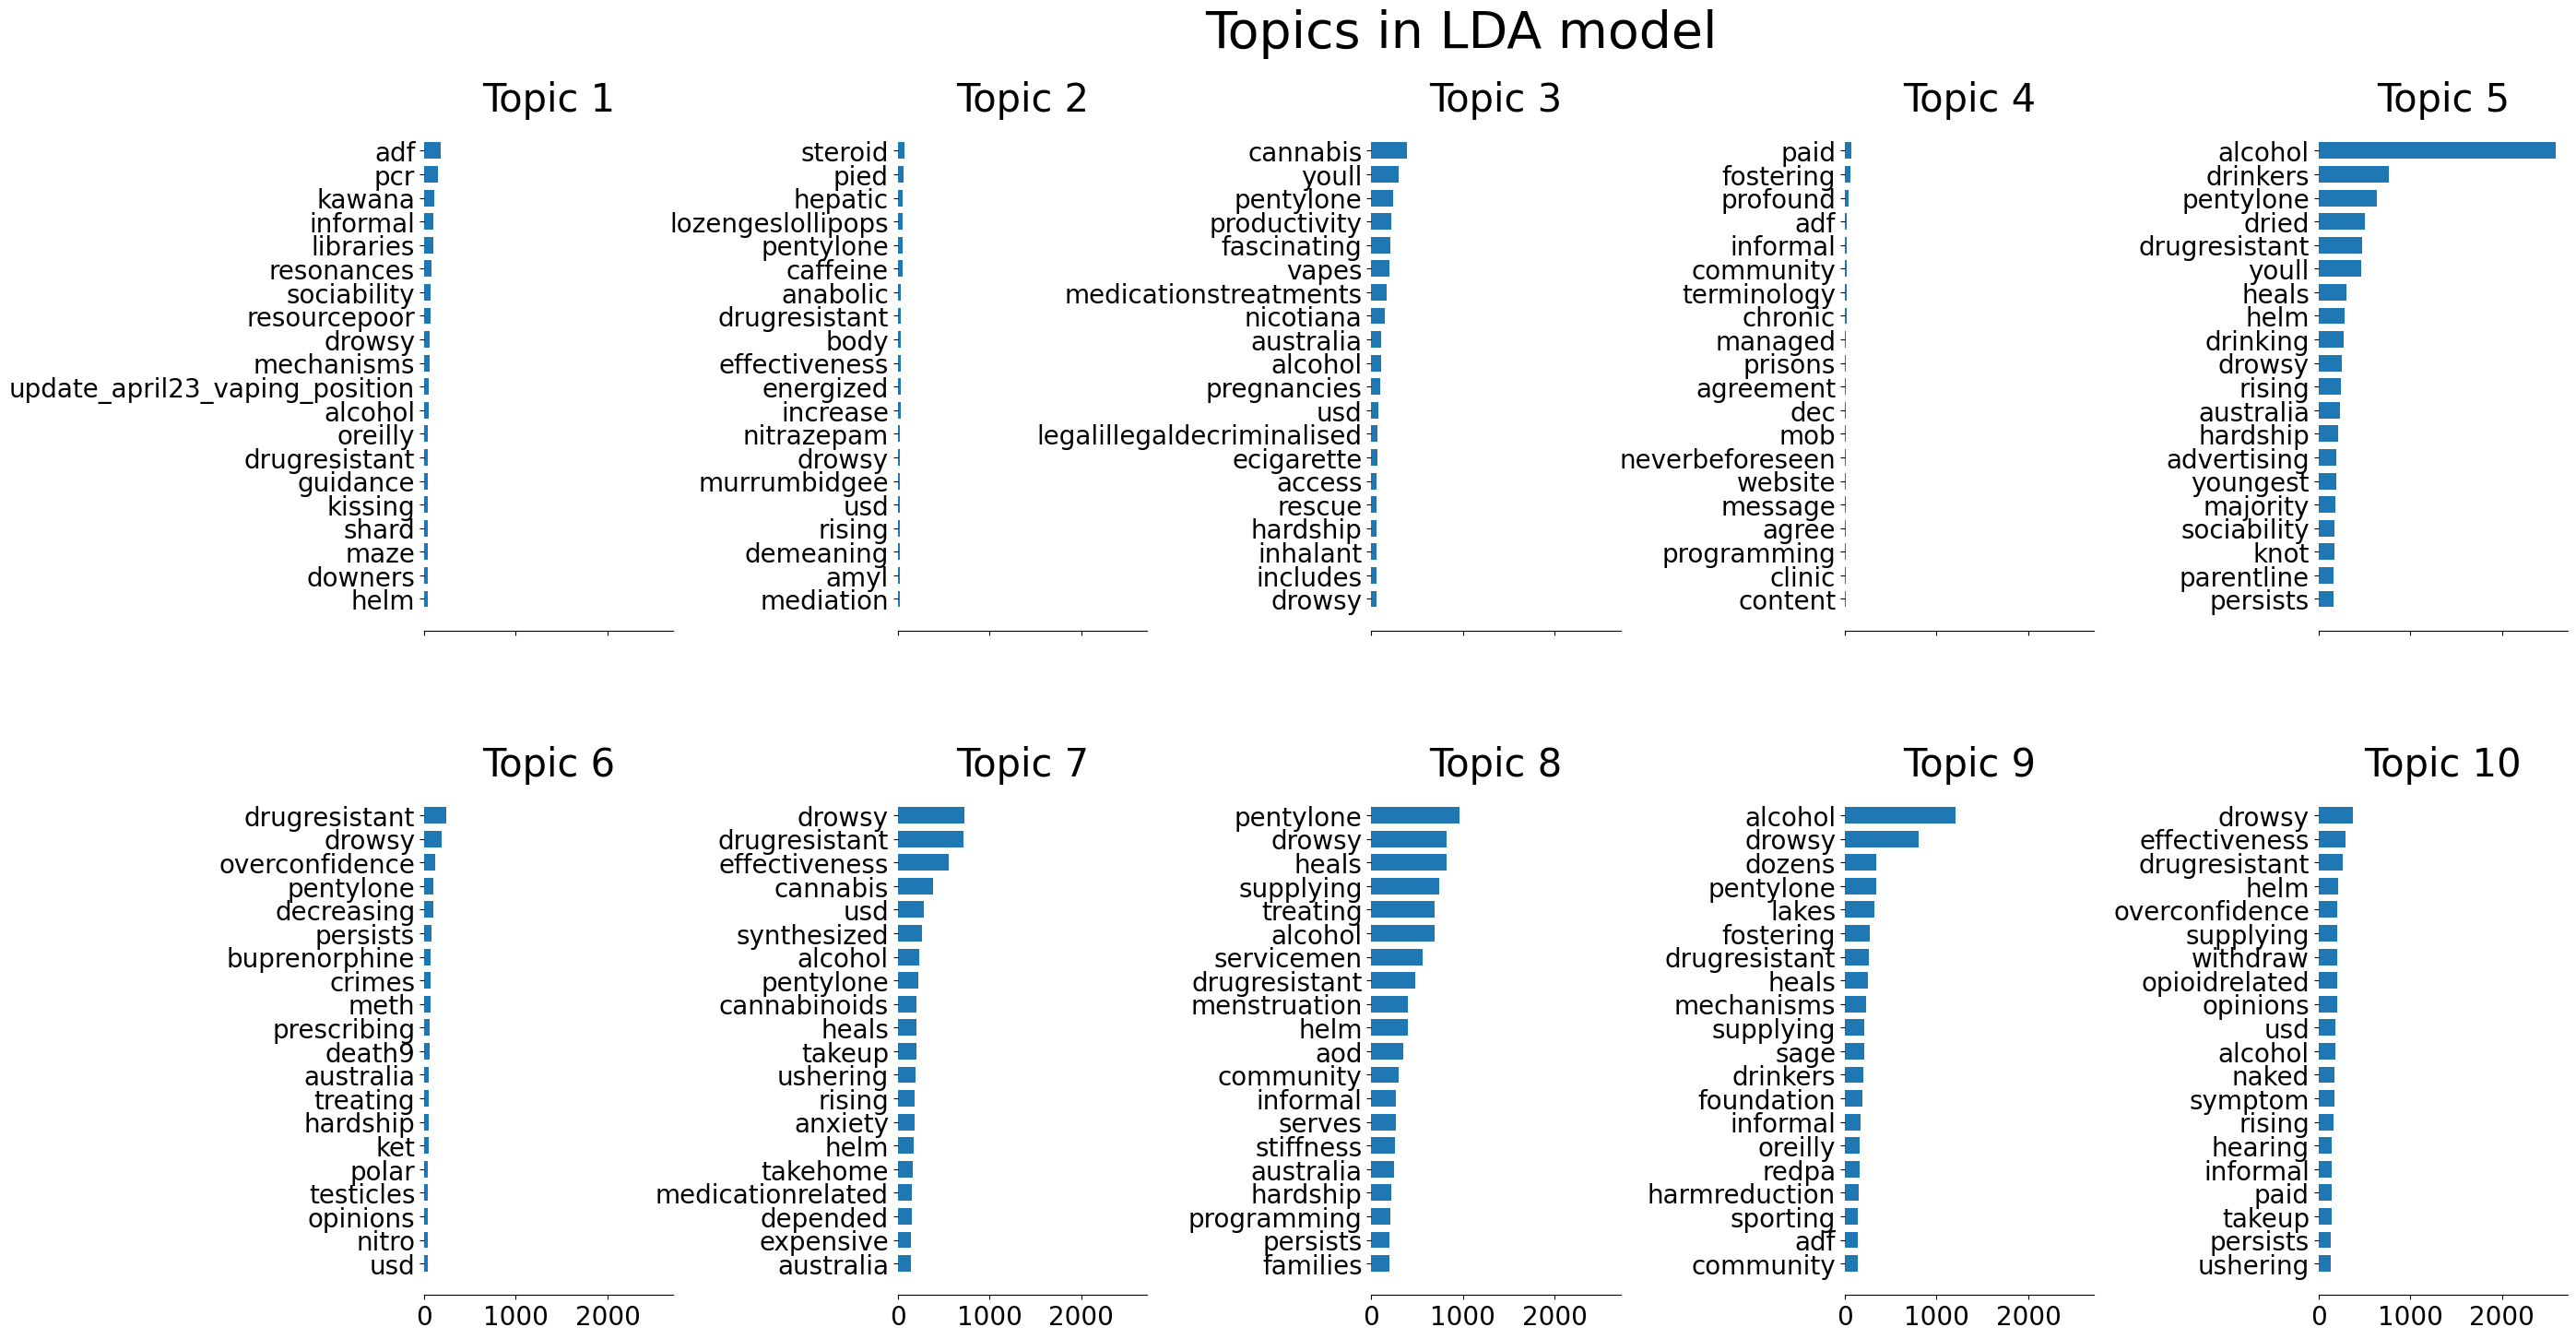

In [88]:
from sklearn.feature_extraction.text import CountVectorizer
#from sklearn.decomposition import LatentDirichletAllocation
stop_words_list
# Vectorizer with stop words

n_samples = 2000
n_features = 1000
n_components = 10
n_top_words = 20
batch_size = 128

def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[-n_top_words:]
        top_features = feature_names[top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

vectorizer = CountVectorizer(stop_words=stop_words_list)
X = vectorizer.fit_transform(cleaned_data['text'])

# Create LDA model
lda = LatentDirichletAllocation(n_components=10)

# Fit LDA model on count data instead of tf-idf
lda.fit(X)

# Plot topics
plot_top_words(lda, feature_names, n_top_words, "Topics in LDA model")

<!-- References
  <h2 id="references">References</h2>
      <li id="fn-1">
      <a href="#fn-1">[1]</a> https://slator.com/large-language-models-really-good-at-data-cleaning-research-finds/
    </li>
    <li id="fn-2">
      <a href="#fn-2">[2]</a> https://www.lettria.com/blogpost/data-cleaning-before-training-an-llm
    </li>
        <li id="fn-3">
      <a href="#fn-3">[3]</a> https://medium.com/@meta_heuristic/3-must-have-techniques-for-data-ingestion-into-llm-and-langchain-1cd751477be
    </li>

     -->